# Raw Data Interpretation

In [ ]:
# 1. Install Required Packages
!pip install pandas numpy matplotlib seaborn openpyxl plotly --quiet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Water data cleaned: (574414, 9)
✅ Weather data cleaned: (28123, 32)


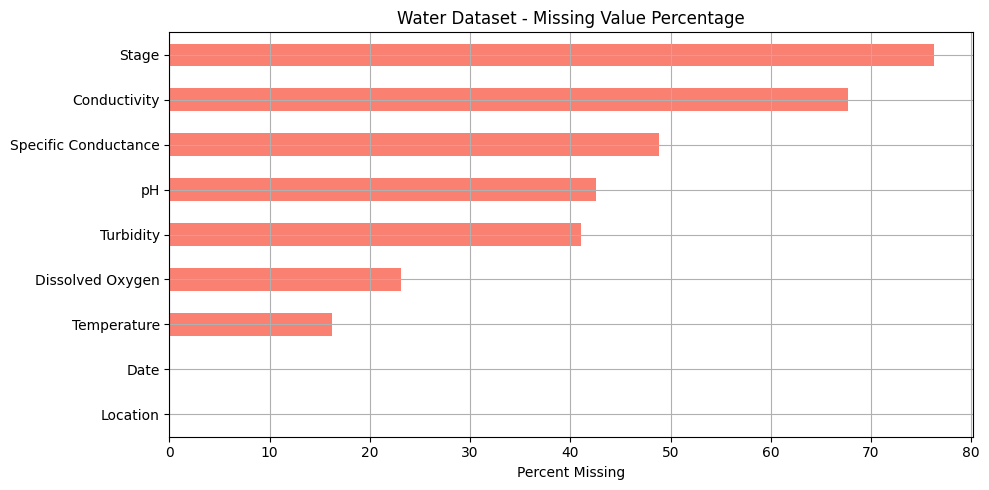

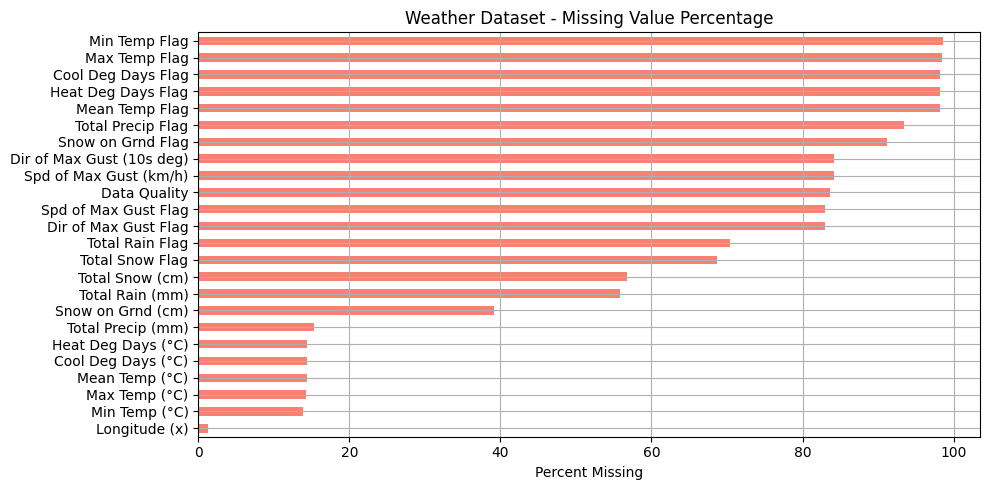

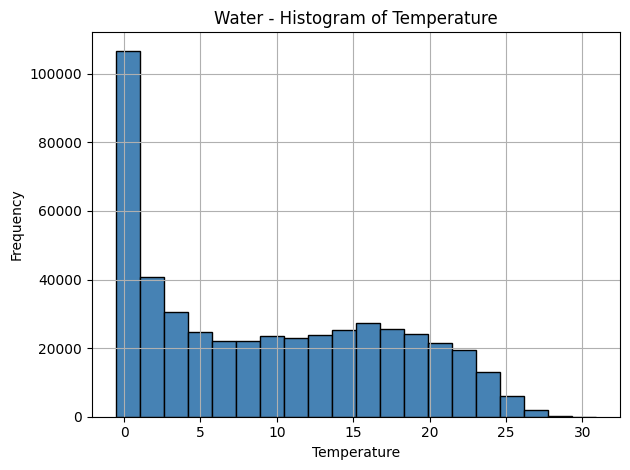

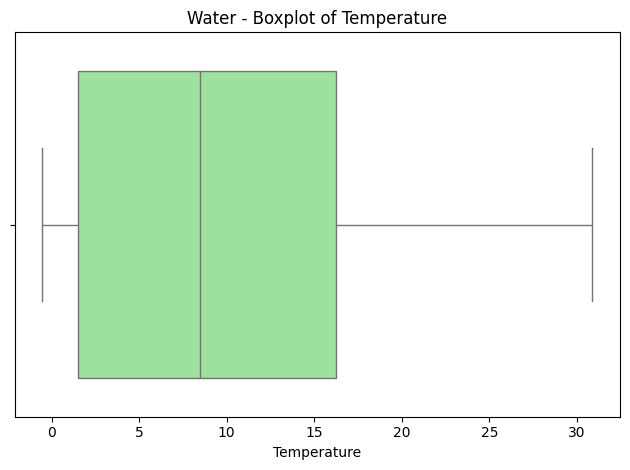

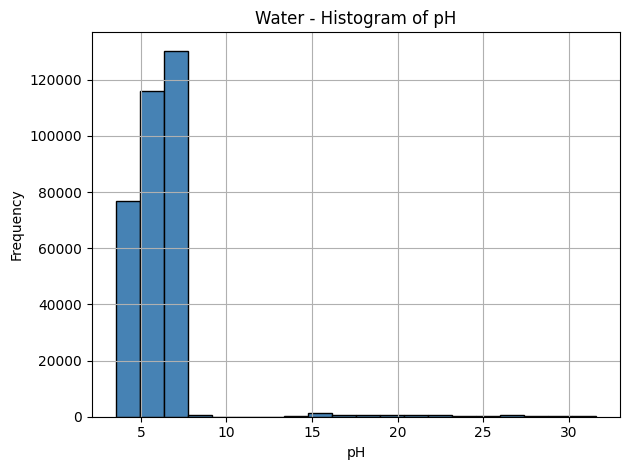

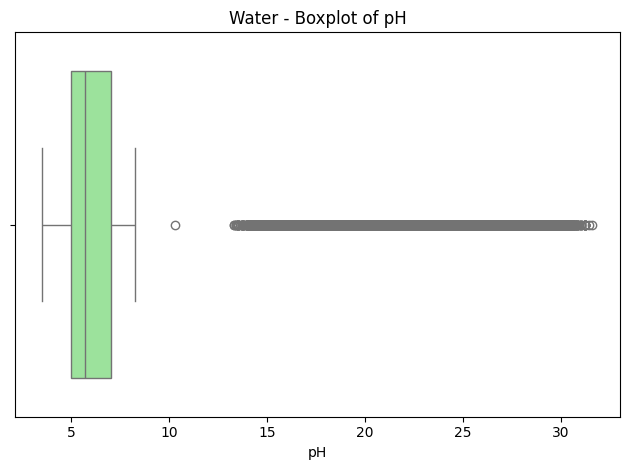

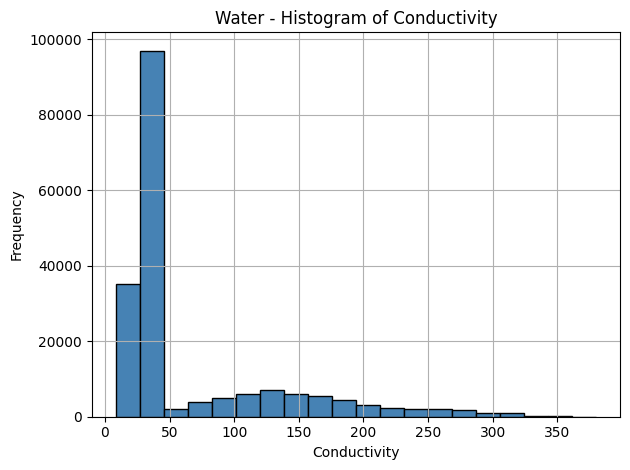

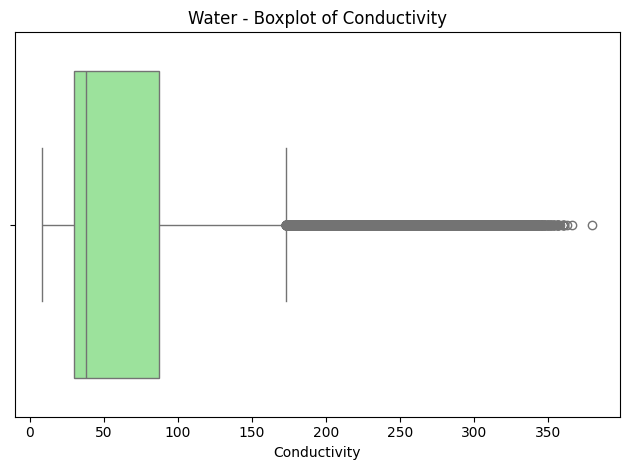

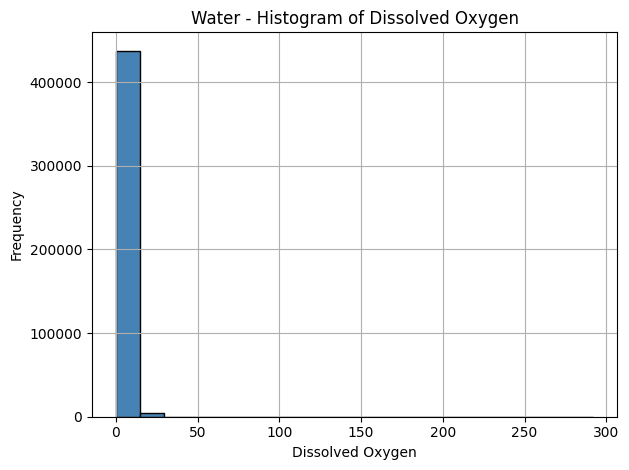

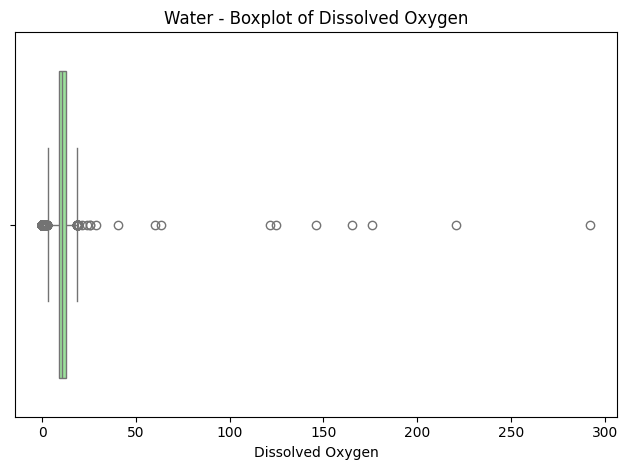

⚠️ Skipping Turbidity in Water due to low variance or extreme values.


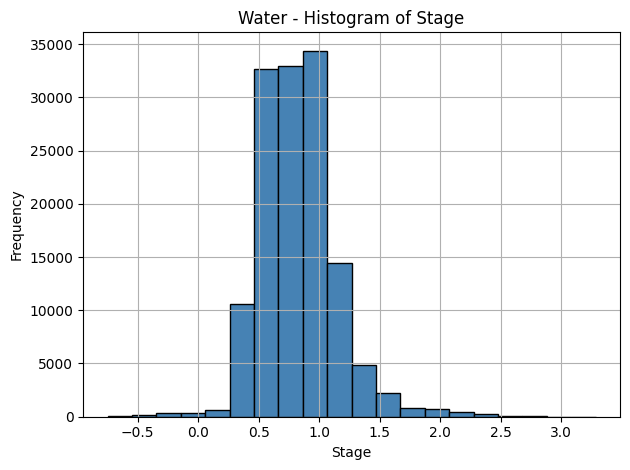

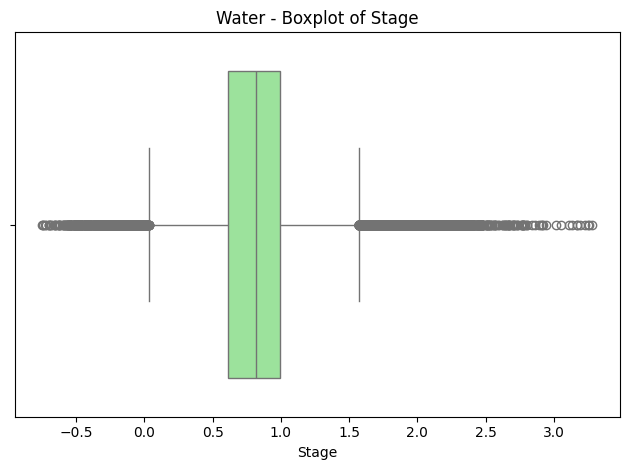

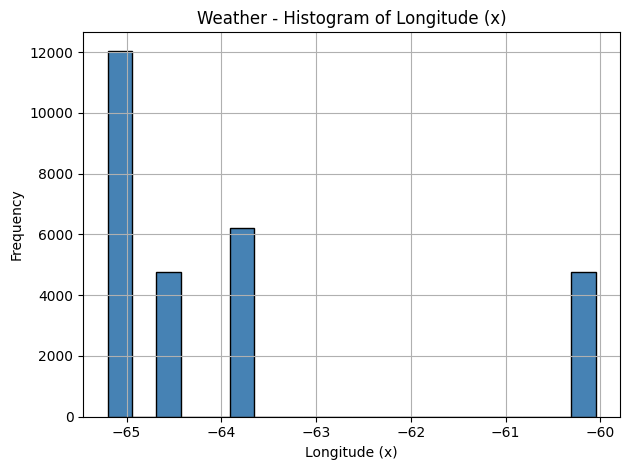

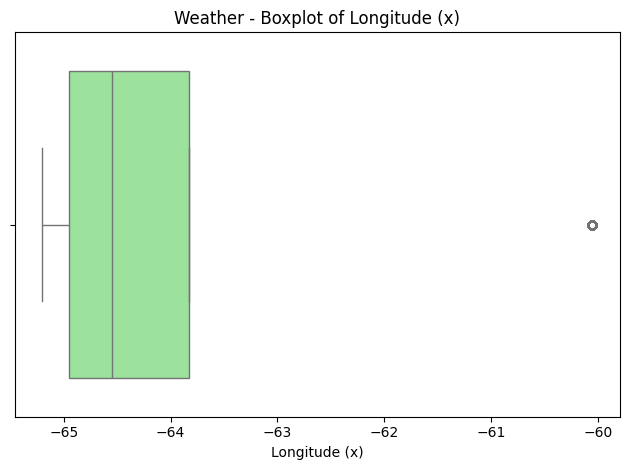

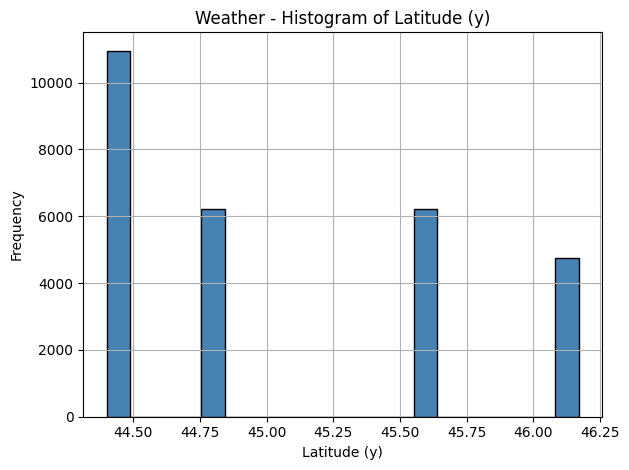

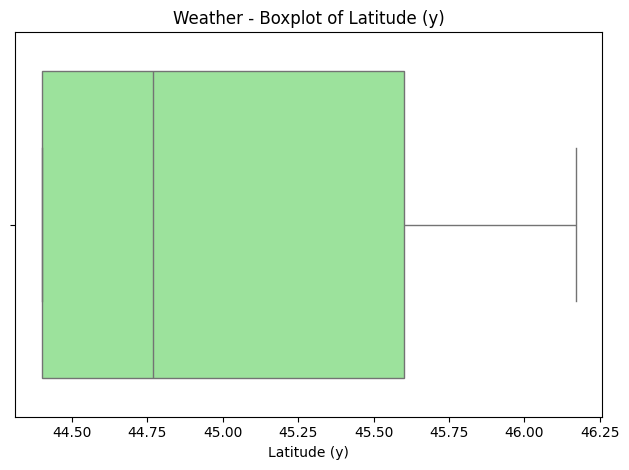

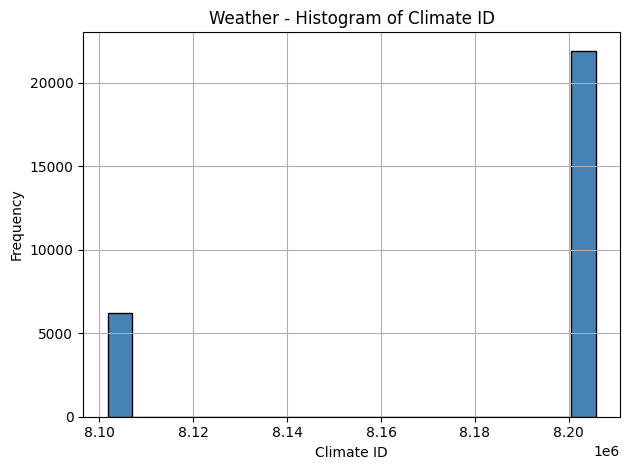

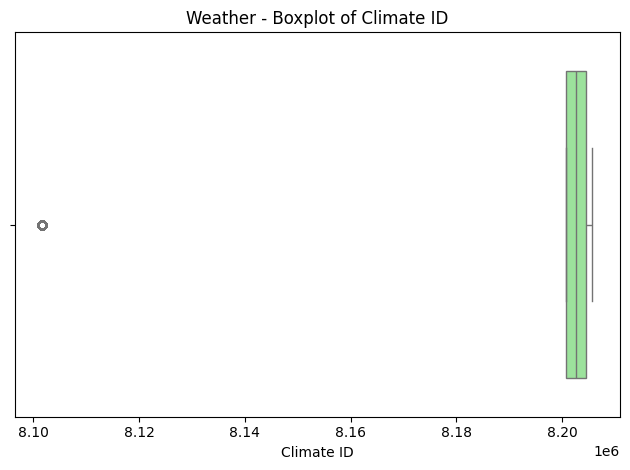

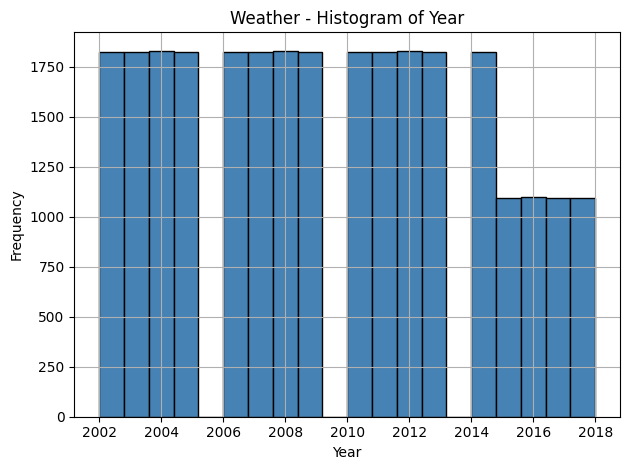

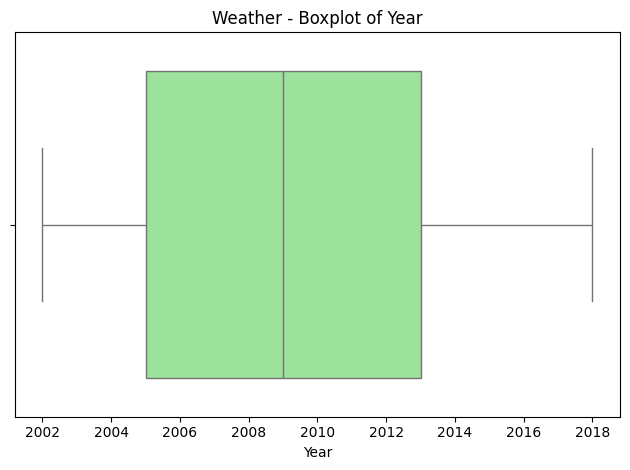

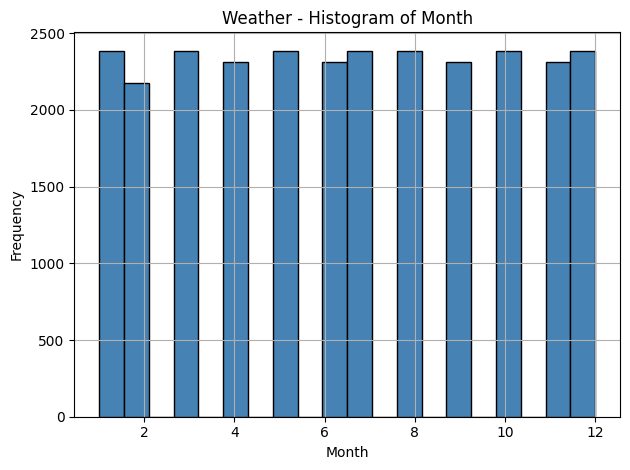

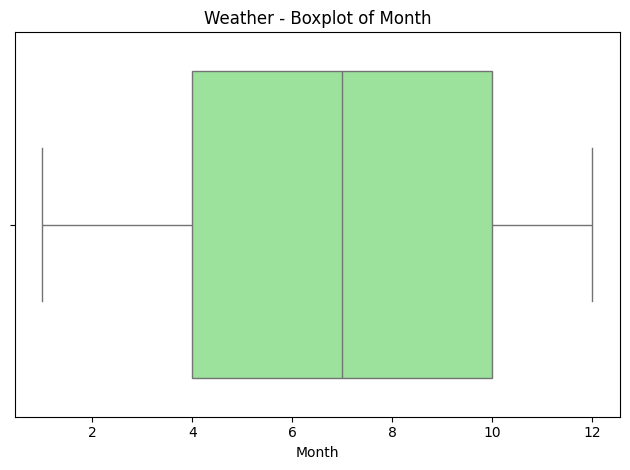

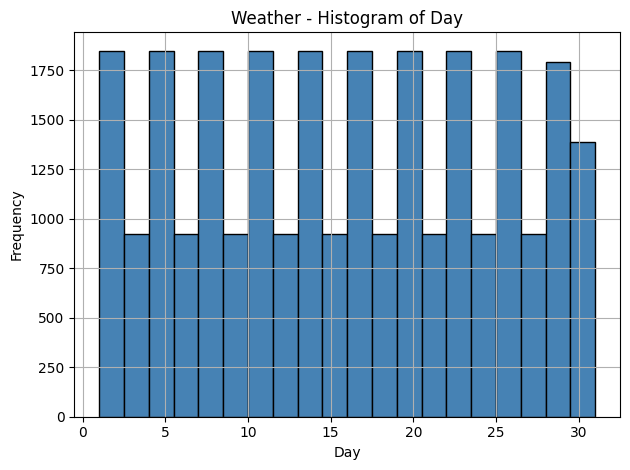

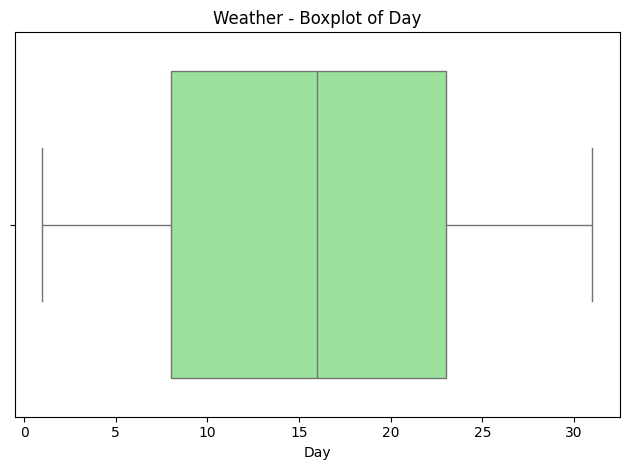

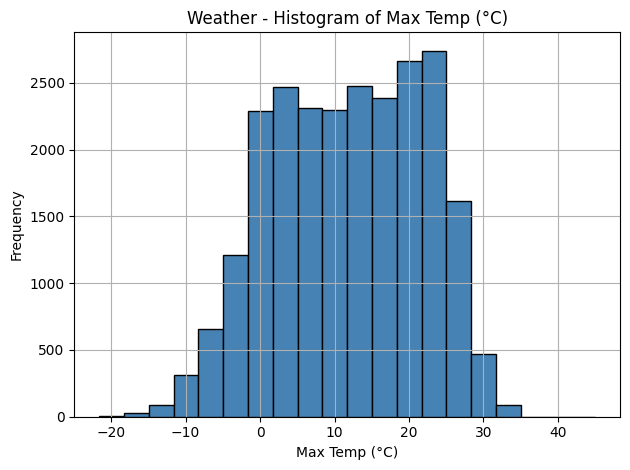

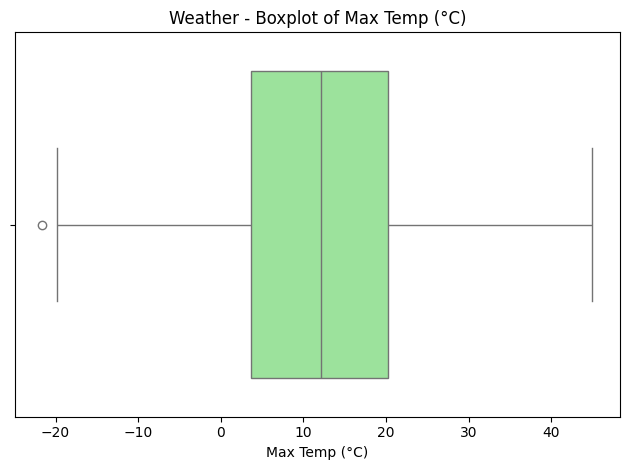

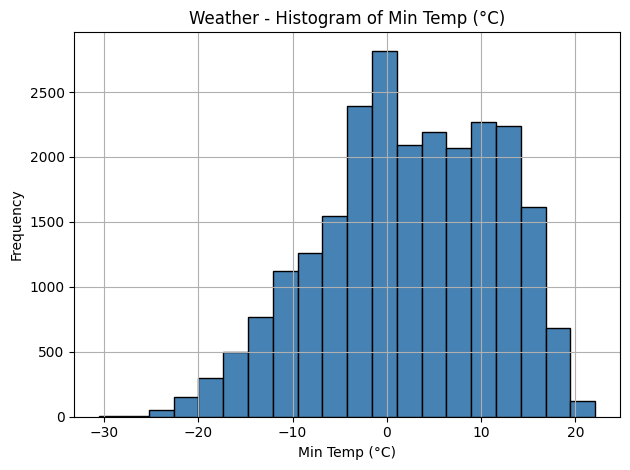

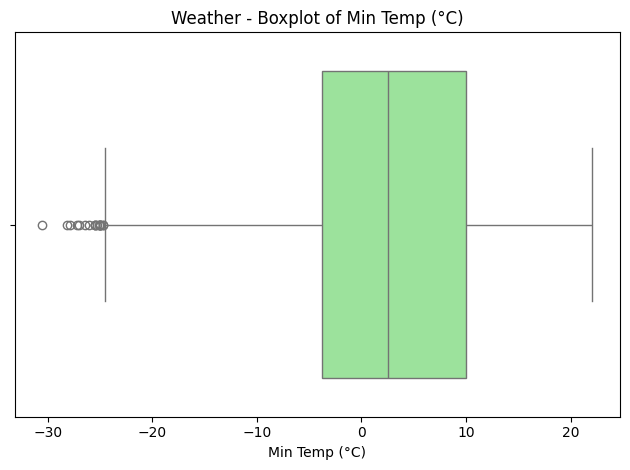

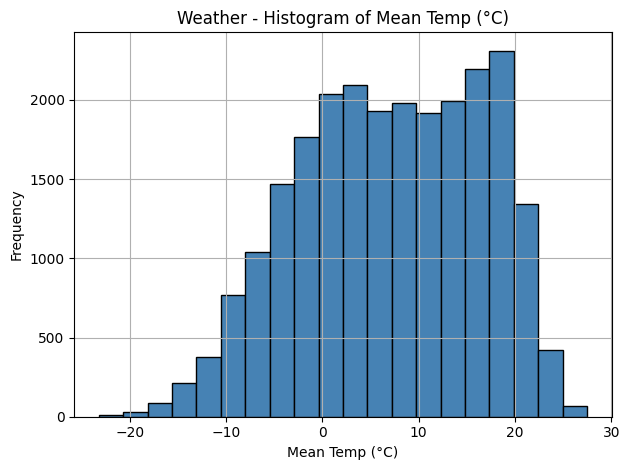

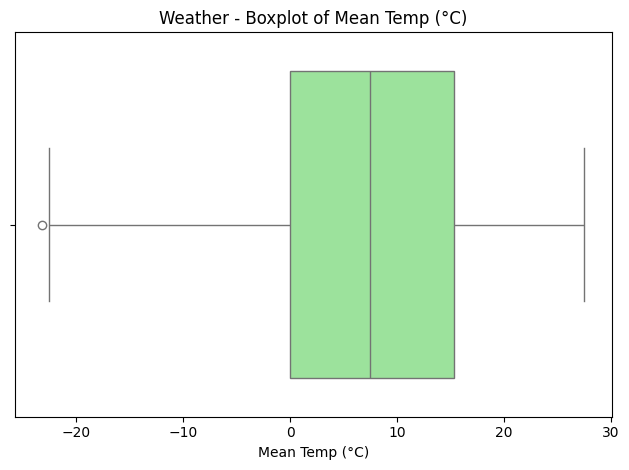

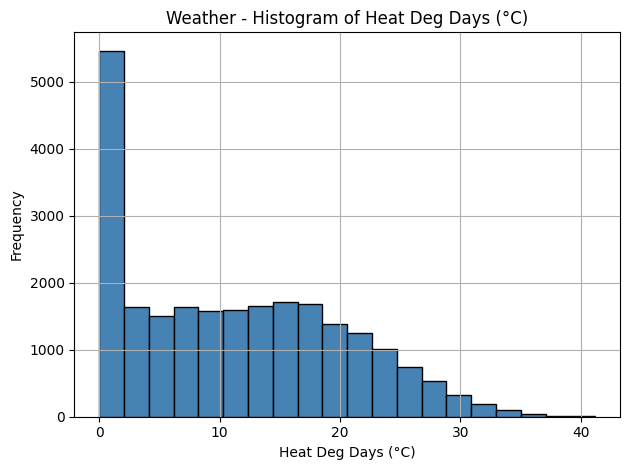

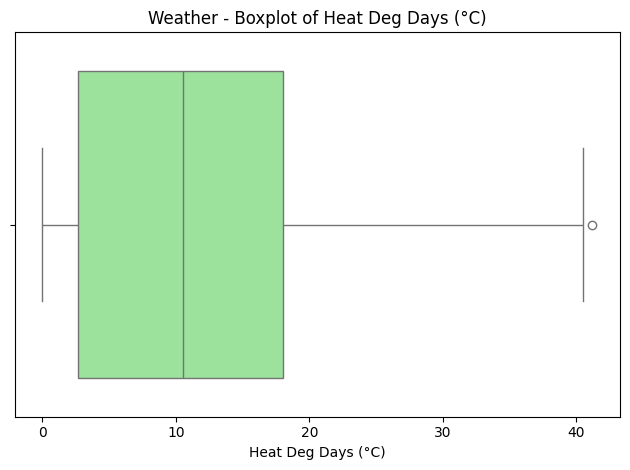

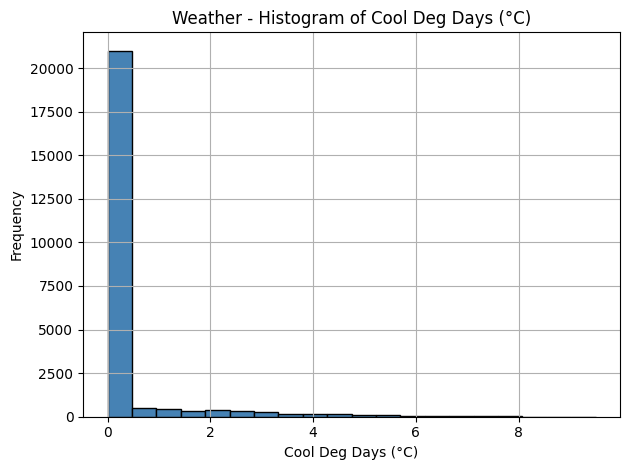

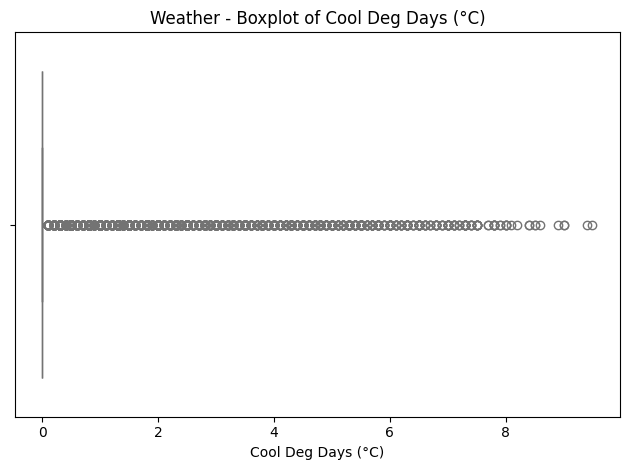

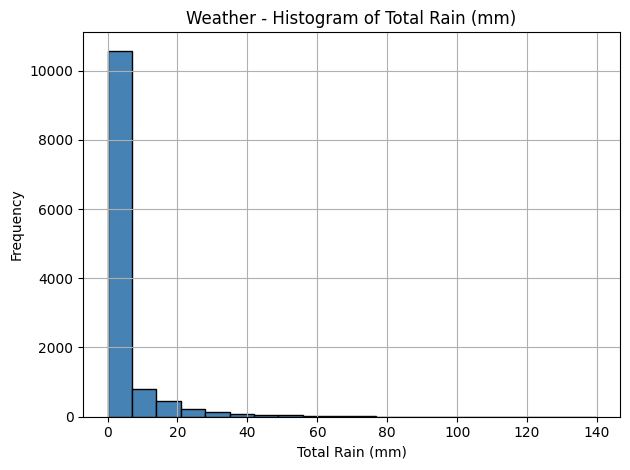

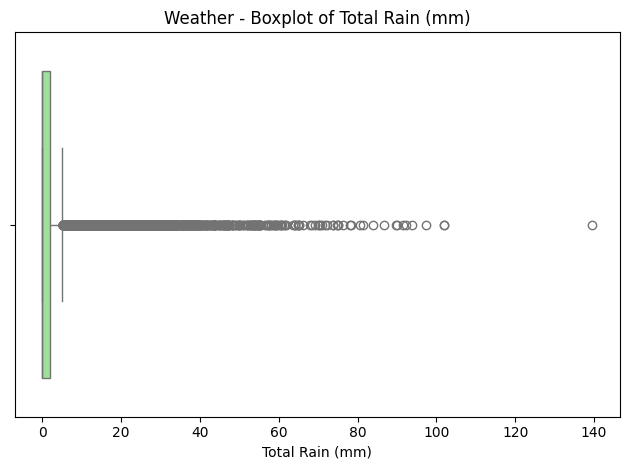

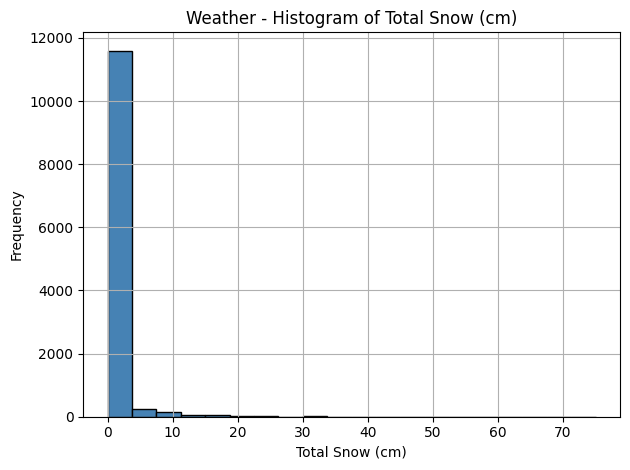

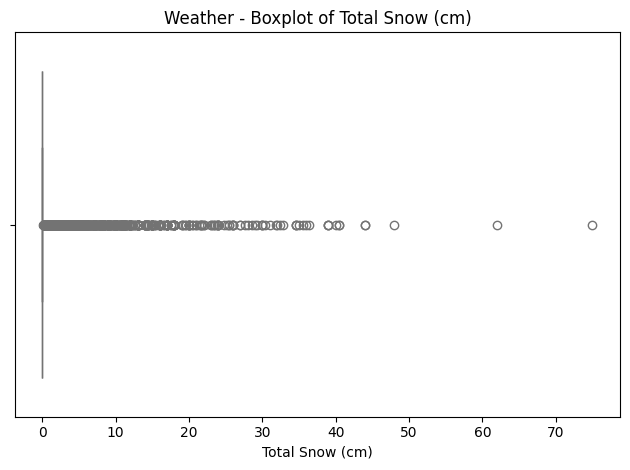

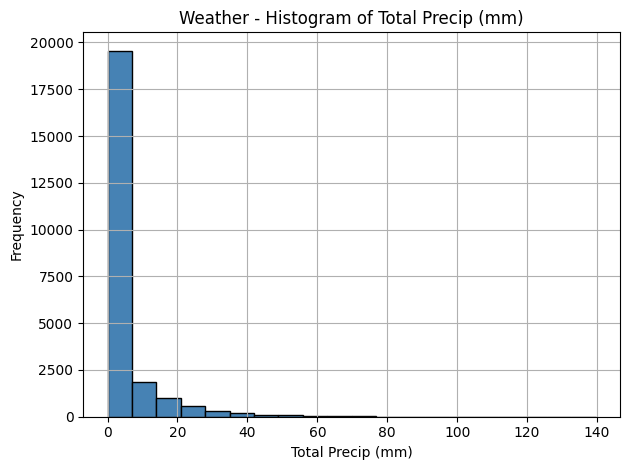

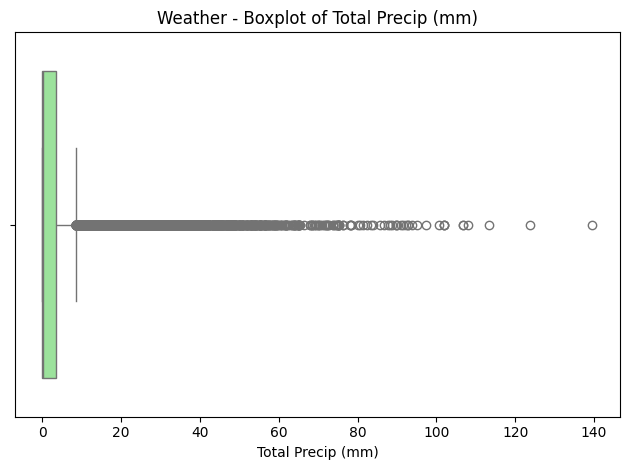

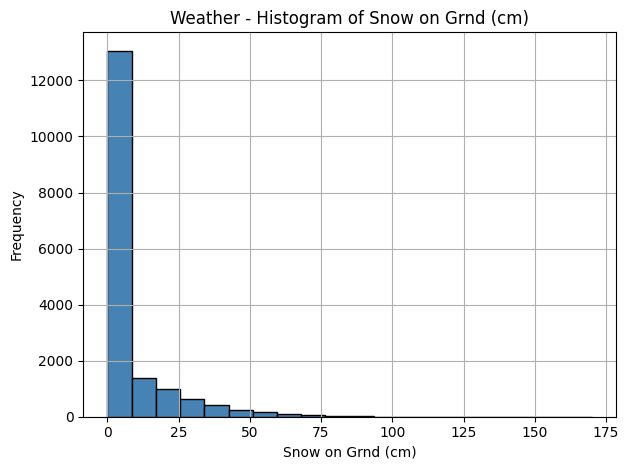

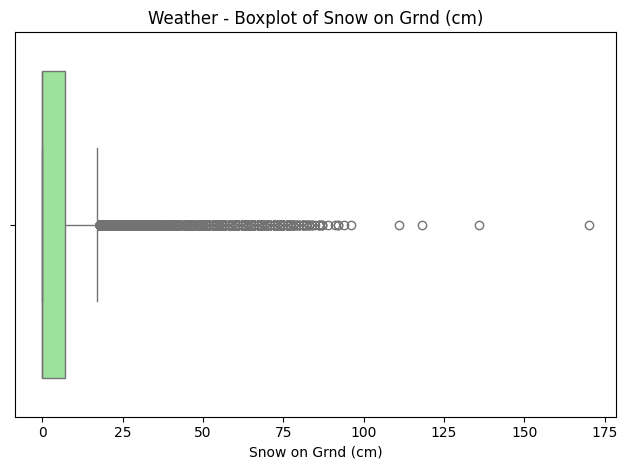

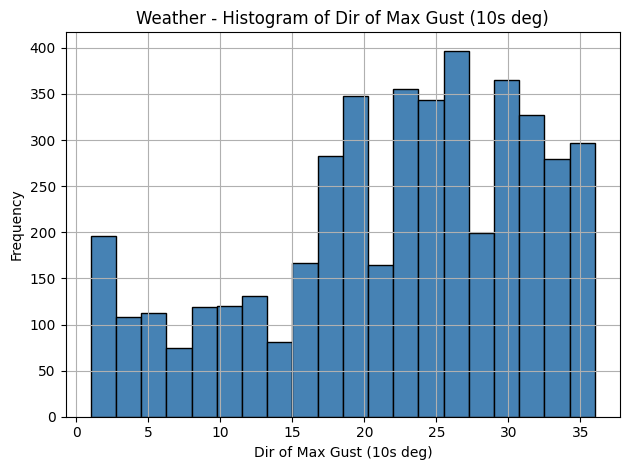

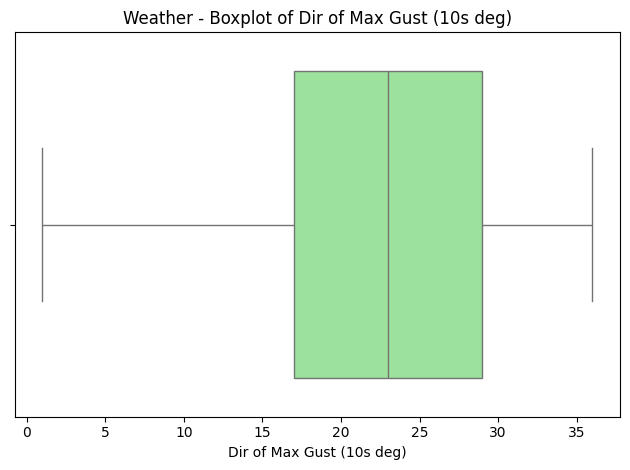

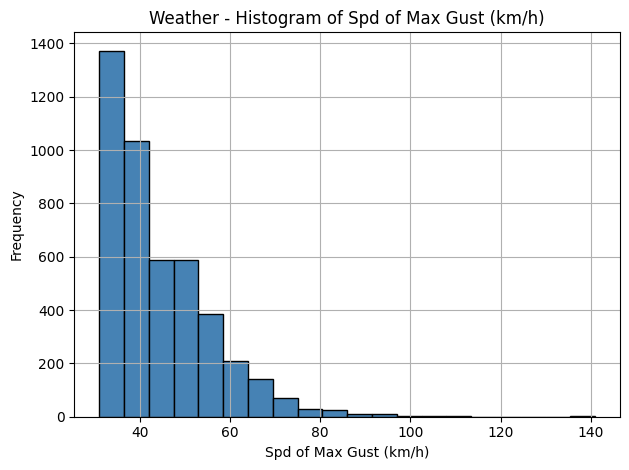

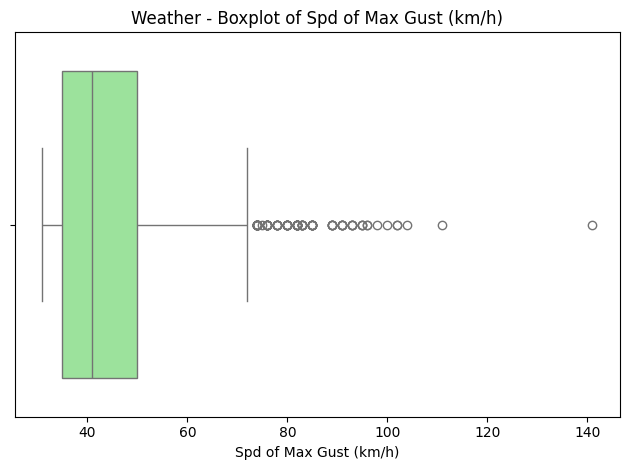

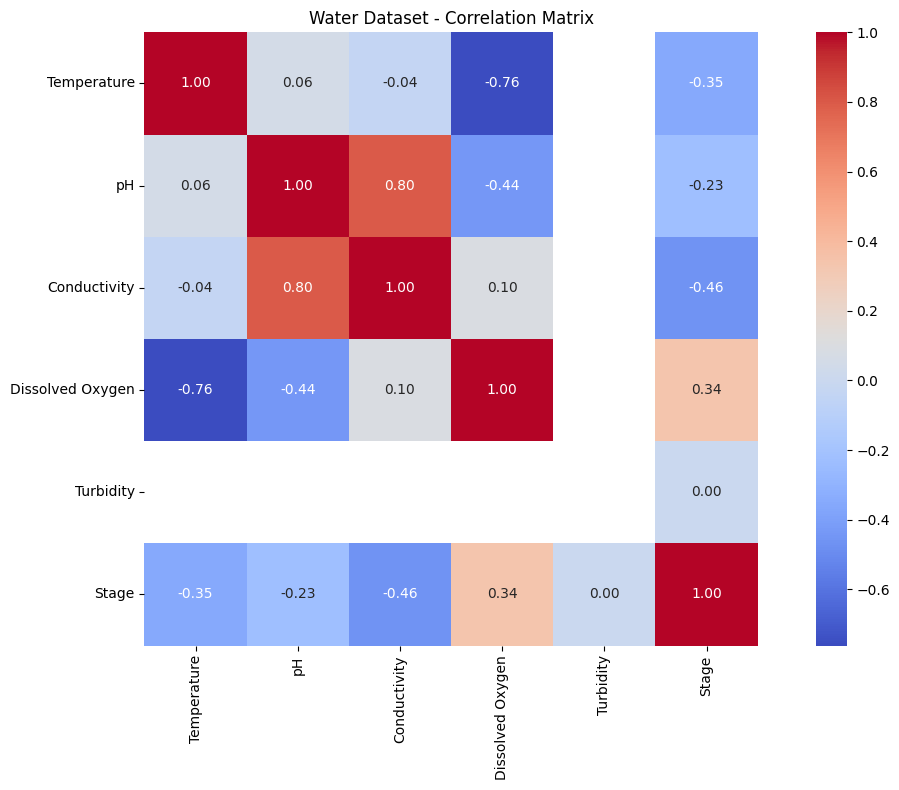

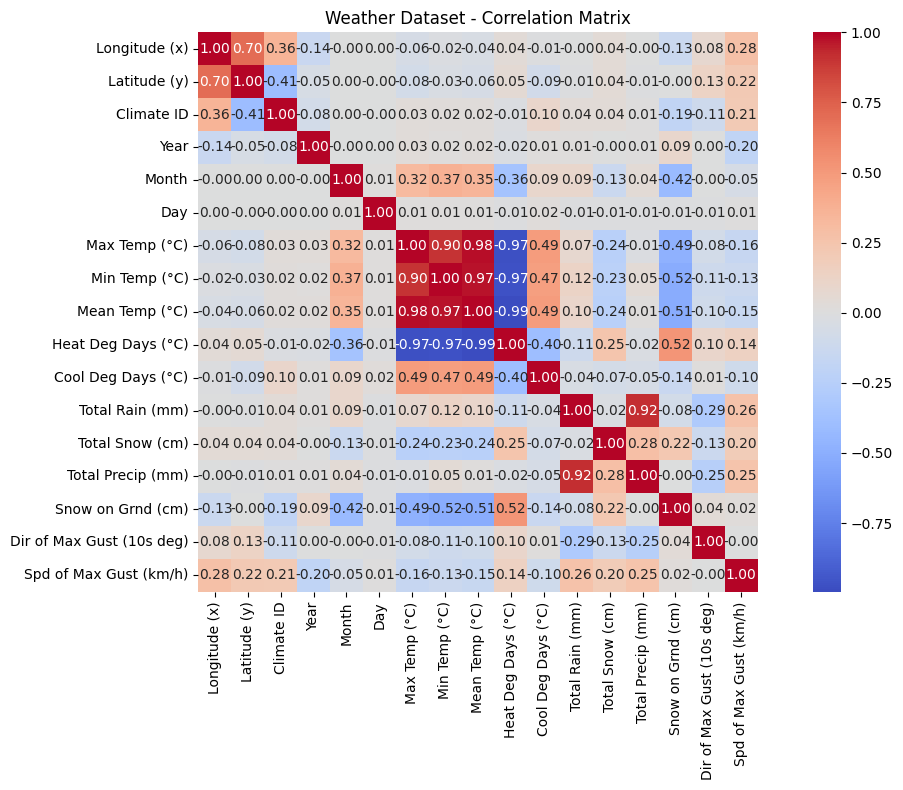

In [ ]:
# 2. Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')


# 3. Import Libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, skew, kurtosis
from IPython.display import display


# 4. Set Folder Paths on Google Drive - path where actual raw data are downloaded from websites

water_folder = '/content/drive/MyDrive/Data_Mining/water'
weather_folder = '/content/drive/MyDrive/Data_Mining/weather'


# 5. Load Water Quality Spreadsheet Files

water_dfs = []
for file in os.listdir(water_folder):
    if file.endswith('.xlsx') or file.endswith('.xls'):
        df = pd.read_excel(os.path.join(water_folder, file))
        water_dfs.append(df)
water_df = pd.concat(water_dfs, ignore_index=True)


# 6. Load Weather CSV Files

weather_dfs = []
for file in os.listdir(weather_folder):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(weather_folder, file))
        weather_dfs.append(df)
weather_df = pd.concat(weather_dfs, ignore_index=True)


# 7. Define Numeric Columns (All columns from both the dataset - Manual Whitelisting)

water_numeric_columns = ['Temperature','pH','Conductivity', 'Dissolved Oxygen','Turbidity', 'Stage']
weather_numeric_columns = [
    'Longitude (x)','Latitude (y)','Max Temp (°C)',	'Min Temp (°C)','Mean Temp (°C)',	'Heat Deg Days (°C)',	'Cool Deg Days (°C)',
    'Total Rain (mm)', 'Total Snow (cm)',	'Total Precip (mm)','Snow on Grnd (cm)','Spd of Max Gust (km/h)'
]


# 8. Data Cleaning Function

def clean_and_convert(df, name, numeric_columns=None):
    df.columns = df.columns.str.strip()
    df = df.loc[:, ~df.columns.duplicated()]
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

    if numeric_columns:
        for col in numeric_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

    print(f"{name} data cleaned: {df.shape}")
    return df

water_df = clean_and_convert(water_df, "Water", water_numeric_columns)
weather_df = clean_and_convert(weather_df, "Weather", weather_numeric_columns)


# 9. Styled Basic Info Table

def styled_basic_info(df, name):
    missing_percent = df.isnull().mean() * 100
    summary = pd.DataFrame({
        'Data Type': df.dtypes,
        'Missing (%)': missing_percent,
        'Unique Values': df.nunique(),
    })
    styled = summary.style.background_gradient(cmap='Oranges')\
                      .set_caption(f"{name} Dataset Summary")\
                      .format({'Missing (%)': '{:.2f}'})
    display(styled)

styled_basic_info(water_df, "Water")
styled_basic_info(weather_df, "Weather")


# 10. Missing Data Plot

def plot_missing_data(df, name):
    missing = df.isnull().mean() * 100
    missing = missing[missing > 0]
    if missing.empty:
        print(f"No missing values in {name} dataset.")
        return
    plt.figure(figsize=(10, 5))
    missing.sort_values().plot(kind='barh', color='salmon')
    plt.title(f"{name} Dataset - Missing Value Percentage")
    plt.xlabel("Percent Missing")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_missing_data(water_df, "Water")
plot_missing_data(weather_df, "Weather")


# 11. Histograms & Boxplots

def plot_distributions(df, name):
    numeric_cols = df.select_dtypes(include=np.number).columns

    for col in numeric_cols:
        col_data = df[col].replace([np.inf, -np.inf], np.nan).dropna()

        if col_data.nunique() < 2 or col_data.max() - col_data.min() > 1e6:
            print(f"Skipping {col} in {name} due to low variance or extreme values.")
            continue

        plt.figure()
        plt.hist(col_data, bins=20, color='steelblue', edgecolor='black')
        plt.title(f"{name} - Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plt.figure()
        sns.boxplot(x=col_data, color='lightgreen')
        plt.title(f"{name} - Boxplot of {col}")
        plt.tight_layout()
        plt.show()

plot_distributions(water_df, "Water")
plot_distributions(weather_df, "Weather")


# 12. Basic Outlier Detection Table

def detect_outliers_styled(df, name):
    numeric_cols = df.select_dtypes(include=np.number)
    z_scores = np.abs(zscore(numeric_cols, nan_policy='omit'))
    outlier_count = pd.Series((z_scores > 3).sum(), index=numeric_cols.columns)
    outliers = outlier_count[outlier_count > 0].to_frame(name='Outlier Count')

    styled = outliers.style.background_gradient(cmap='Reds')\
                          .set_caption(f"{name} Dataset - Outliers (Z-score > 3)")\
                          .format(precision=0)
    display(styled)

detect_outliers_styled(water_df, "Water")
detect_outliers_styled(weather_df, "Weather")


# 13. Correlation Matrix

def plot_correlation(df, name):
    numeric_cols = df.select_dtypes(include=np.number)

    if numeric_cols.shape[1] < 2:
        print(f"Not enough numeric columns for {name} correlation matrix.")
        return

    corr = numeric_cols.corr()

    if corr.isnull().values.all():
        print(f"Correlation matrix for {name} contains only NaNs.")
        return

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title(f"{name} Dataset - Correlation Matrix")
    plt.tight_layout()
    plt.show()

plot_correlation(water_df, "Water")
plot_correlation(weather_df, "Weather")


# 14. Skewness & Kurtosis Table

def skew_kurtosis_table(df, name):
    numeric_cols = df.select_dtypes(include=np.number)

    # Drop columns with all NaNs or constant values
    valid_cols = []
    for col in numeric_cols.columns:
        col_data = numeric_cols[col].dropna()
        if len(col_data) > 1 and col_data.nunique() > 1:
            valid_cols.append(col)

    if not valid_cols:
        print(f"No valid numeric columns found for skewness/kurtosis in {name}.")
        return

    stats = {
        'Skewness': numeric_cols[valid_cols].apply(lambda x: skew(x.dropna())),
        'Kurtosis': numeric_cols[valid_cols].apply(lambda x: kurtosis(x.dropna()))
    }
    summary = pd.DataFrame(stats)
    styled = summary.style.background_gradient(cmap='Blues')\
                          .set_caption(f"{name} Dataset - Skewness & Kurtosis")\
                          .format("{:.2f}")
    display(styled)


skew_kurtosis_table(water_df, "Water")
skew_kurtosis_table(weather_df, "Weather")


Plot distribution analysis

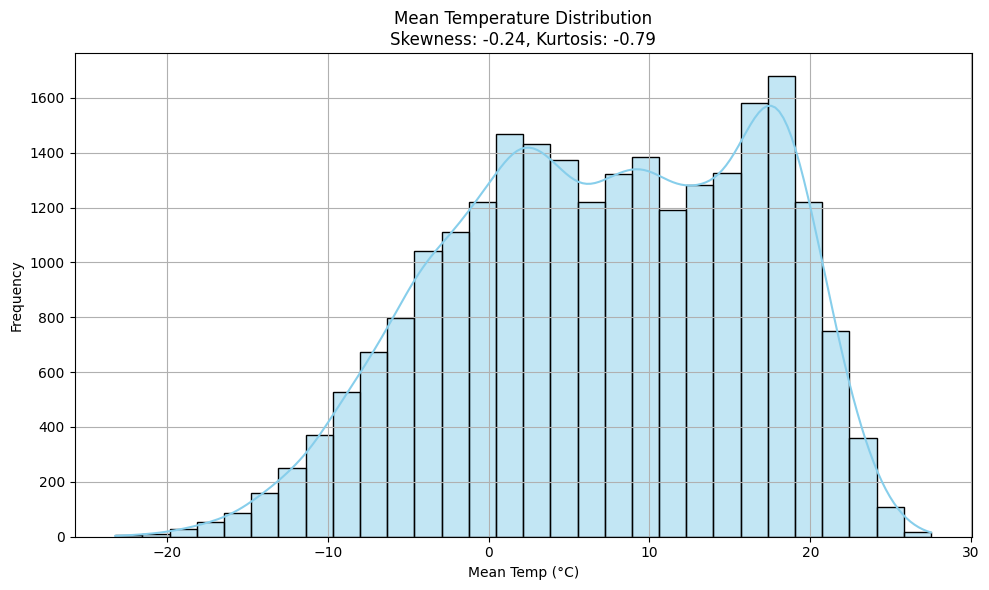

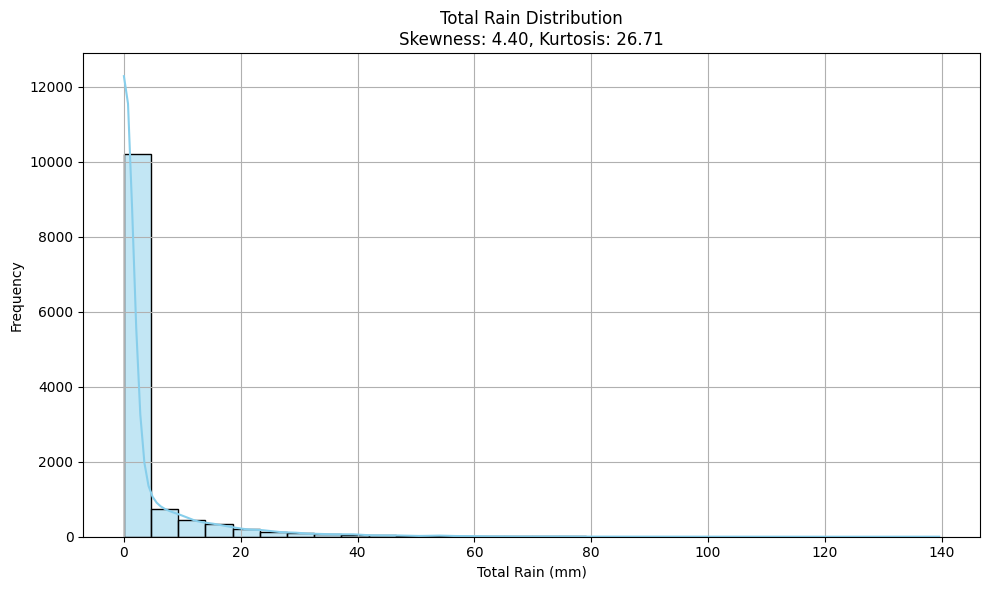

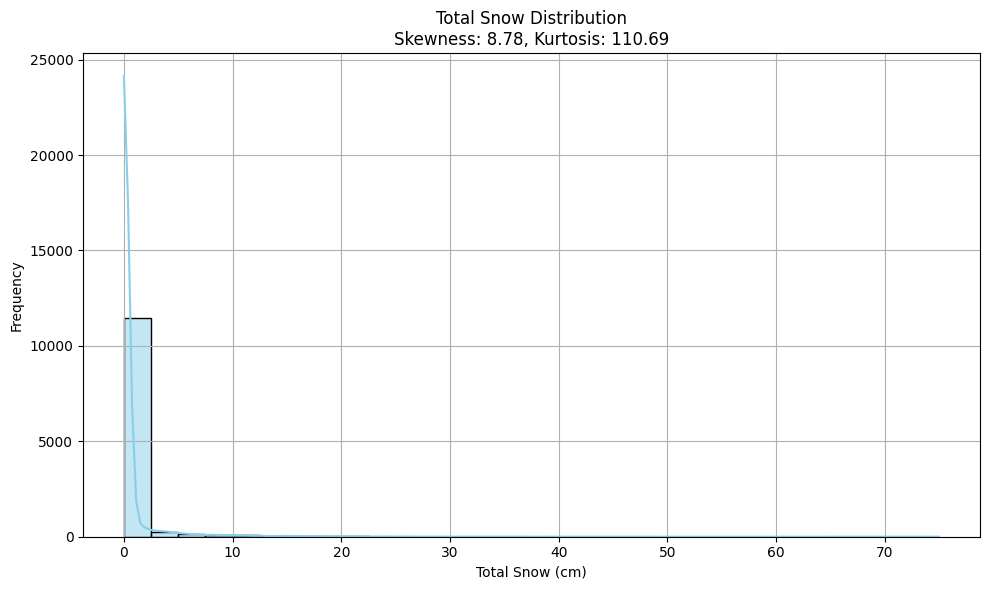

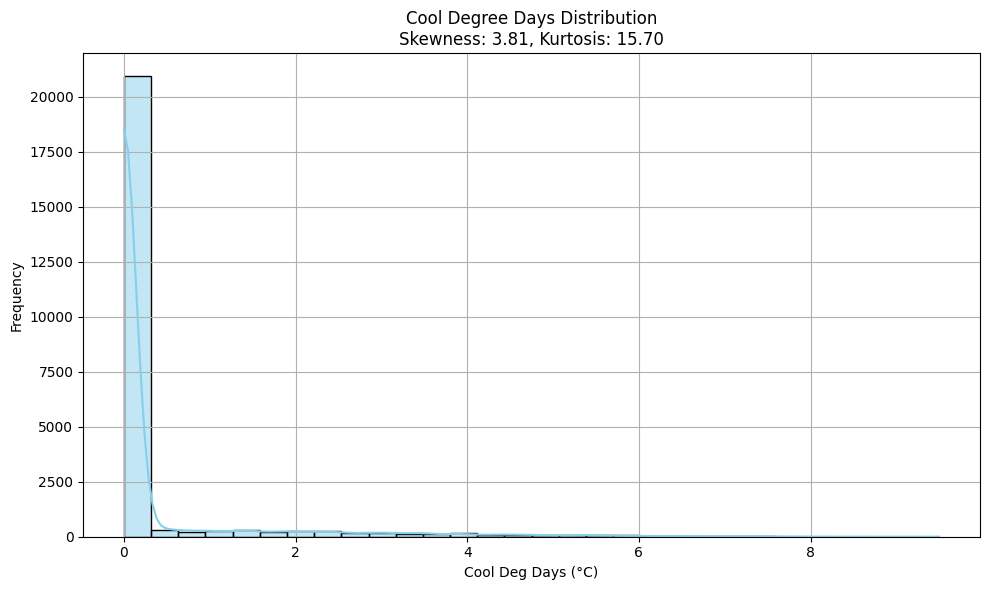

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

def plot_distribution_analysis(df, column, title=None):
    # Drop NaN values and compute statistics
    data = df[column].dropna()
    s = skew(data)
    k = kurtosis(data)

    # Create histogram with density plot (KDE)
    plt.figure(figsize=(10, 6))
    sns.histplot(data, kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.title(f"{title if title else column}\nSkewness: {s:.2f}, Kurtosis: {k:.2f}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot distribution analysis for each key variable.
plot_distribution_analysis(weather_df, "Mean Temp (°C)", "Mean Temperature Distribution")
plot_distribution_analysis(weather_df, "Total Rain (mm)", "Total Rain Distribution")
plot_distribution_analysis(weather_df, "Total Snow (cm)", "Total Snow Distribution")
plot_distribution_analysis(weather_df, "Cool Deg Days (°C)", "Cool Degree Days Distribution")


# Dataset Merging & Handling Missing Value

In [ ]:
# 1. Install Required Packages

!pip install pandas numpy matplotlib seaborn openpyxl scikit-learn plotly --quiet

In [ ]:


# 2. Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')


# 3. Import Libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, skew, kurtosis
from IPython.display import display
from sklearn.impute import KNNImputer


# 4. Set Folder Paths on Google Drive


water_folder = '/content/drive/MyDrive/Data_Mining/water'
weather_folder = '/content/drive/MyDrive/Data_Mining/weather'


# 5. Load Water Excel Files

water_dfs = []
for file in os.listdir(water_folder):
    if file.endswith('.xlsx') or file.endswith('.xls'):
        df = pd.read_excel(os.path.join(water_folder, file))
        water_dfs.append(df)
water_df = pd.concat(water_dfs, ignore_index=True)


# 6. Load Weather CSV Files

weather_dfs = []
for file in os.listdir(weather_folder):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(weather_folder, file))
        weather_dfs.append(df)
weather_df = pd.concat(weather_dfs, ignore_index=True)


# 7. Define Numeric Columns

water_numeric_columns = ['Temperature','pH','Conductivity', 'Dissolved Oxygen','Turbidity', 'Stage']
weather_numeric_columns = [
    'Longitude (x)','Latitude (y)','Max Temp (°C)','Min Temp (°C)','Mean Temp (°C)',
    'Heat Deg Days (°C)','Cool Deg Days (°C)','Total Rain (mm)', 'Total Snow (cm)',
    'Total Precip (mm)','Snow on Grnd (cm)','Spd of Max Gust (km/h)'
]


# 8. Data Cleaning Function

def clean_and_convert(df, name, numeric_columns=None):
    df.columns = df.columns.str.strip() # Remove extra spaces
    df = df.loc[:, ~df.columns.duplicated()]   # Drop duplicate columns
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]  # Drop 'Unnamed' columns

    # Convert only the whitelisted columns to numeric
    if numeric_columns:
        for col in numeric_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

    print(f"{name} data cleaned: {df.shape}")
    return df

water_df = clean_and_convert(water_df, "Water", water_numeric_columns)
weather_df = clean_and_convert(weather_df, "Weather", weather_numeric_columns)


# 9. Convert Date Columns & Aggregate Water Data to Daily Averages

if 'Date' in water_df.columns:
    water_df['Date'] = pd.to_datetime(water_df['Date'], errors='coerce')
    # Create a new column "Day" (date without time)
    water_df['Day'] = water_df['Date'].dt.date

# Group by 'Location' and 'Day' and compute the mean of the numeric readings
water_daily = water_df.groupby(['Location', 'Day'])[water_numeric_columns].mean().reset_index()
# Rename "Day" back to "Date" for consistency
water_daily.rename(columns={'Day': 'Date'}, inplace=True)

# For weather dataset, convert the "Date" column to date
if 'Date' in weather_df.columns:
    weather_df['Date'] = pd.to_datetime(weather_df['Date'], errors='coerce').dt.date


# 10. Merge Water and Weather Datasets (Inner Join on Location and Date)

merged_df = pd.merge(water_daily, weather_df, on=['Location', 'Date'], how='inner')
print("Merged dataset shape:", merged_df.shape)

# 11. Missing Value Handling with Imputation Counts

# (A) Record the initial number of rows before dropping
initial_rows = merged_df.shape[0]

# (B) Identify numeric columns in the merged dataset
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns.tolist()

# (C) Drop rows with >50% missing in numeric columns and count the drops
before_drop = merged_df.shape[0]
row_missing_pct = merged_df[numeric_cols].isnull().mean(axis=1)
merged_df = merged_df[row_missing_pct <= 0.5]
dropped_rows_count = before_drop - merged_df.shape[0]
print("Dropped rows count:", dropped_rows_count)

# (D) Impute missing values:
# For each numeric column, if missing proportion is <20%, fill using median
median_imputed_count = 0
for col in numeric_cols:
    missing_prop = merged_df[col].isnull().mean()
    if missing_prop < 0.2:
        count = merged_df[col].isnull().sum()
        median_imputed_count += count
        merged_df[col] = merged_df[col].fillna(merged_df[col].median())

# For columns with missing proportion >=20%, use KNN imputation
knn_columns = [col for col in numeric_cols if merged_df[col].isnull().mean() >= 0.2]
knn_imputed_count = 0
if knn_columns:
    # Count missing cells in these columns before imputation
    knn_imputed_count = merged_df[knn_columns].isnull().sum().sum()
    imputer = KNNImputer(n_neighbors=5)
    # Apply KNN imputation on all numeric columns
    merged_df[numeric_cols] = imputer.fit_transform(merged_df[numeric_cols])

print("Median imputed missing cells count (missing proportion <20%):", median_imputed_count)
print("KNN imputed missing cells count (missing proportion >=20%):", knn_imputed_count)


# 12. Descriptive Statistics & Visualizations After Imputation

print("\nDescriptive Statistics for Merged Data (numeric columns):")
display(merged_df[numeric_cols].describe())


# 13. Save the Merged & Imputed Data to CSV for further use
merged_df.to_csv('/content/drive/MyDrive/Data_Mining/merged_imputed_data.csv', index=False)
print("Merged & imputed data saved to Google Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Water data cleaned: (574414, 9)
✅ Weather data cleaned: (28123, 32)
✅ Merged dataset shape: (21281, 38)
Dropped rows count: 3121


<ipython-input-4-8050d56ce764>:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[col] = merged_df[col].fillna(merged_df[col].median())
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:424: RuntimeWarning: overflow encountered in multiply
  distances = -2 * safe_sparse_dot(X, Y.T, dense_output=True)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:426: RuntimeWarning: invalid value encountered in add
  distances += YY
/usr/local/lib/

Median imputed missing cells count (missing proportion <20%): 4393
KNN imputed missing cells count (missing proportion >=20%): 95191

Descriptive Statistics for Merged Data (numeric columns):


/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


Temperature            pH  Conductivity  Dissolved Oxygen  \
count  18160.000000  18160.000000  18160.000000      18160.000000   
mean       9.351787      5.717295     58.284266         10.654829   
std        7.285457      2.228999     57.153923          2.521898   
min       -0.421667      3.706956     13.658333          0.000000   
25%        2.407188      4.502083     26.570442          8.880833   
50%        8.627708      5.254660     35.432500         10.701667   
75%       15.210208      6.356458     40.699714         12.702977   
max       27.717500     30.883333    353.083333         17.765714   

           Turbidity         Stage  Longitude (x)  Latitude (y)    Climate ID  \
count   1.816000e+04  18160.000000   18160.000000  18160.000000  1.816000e+04   
mean   3.900514e+302      0.984088     -63.651720     45.157192  8.179382e+06   
std              inf      0.440155       1.994831      0.707822  4.355763e+04   
min     0.000000e+00     -0.560292     -65.200000     44.400000  8.101746e+06   
25%     0.000000e+00      0.681902     -64.950000     44.400000  8.200600e+06   
50%     2.256939e-01      0.881658     -64.550000     44.770000  8.202592e+06   
75%     9.583333e-01      1.094500     -63.830000     45.600000  8.204453e+06   
max    7.083333e+306      2.741917     -60.050000     46.170000  8.205700e+06   

               Year  ...  Min Temp (°C)  Mean Temp (°C)  Heat Deg Days (°C)  \
count  18160.000000  ...   18160.000000    18160.000000        18160.000000   
mean    2009.749009  ...       2.495776        7.182318           11.150006   
std        4.268328  ...       9.218323        9.359174            8.893024   
min     2002.000000  ...     -28.100000      -22.000000            0.000000   
25%     2006.000000  ...      -3.500000        0.200000            2.800000   
50%     2010.000000  ...       2.700000        7.600000           10.400000   
75%     2013.000000  ...      10.000000       15.200000           17.800000   
max     2017.000000  ...      22.100000       27.500000           40.000000   

       Cool Deg Days (°C)  Total Rain (mm)  Total Snow (cm)  \
count        18160.000000     18160.000000     18160.000000   
mean             0.332324         1.763467         0.700266   
std              1.047392         6.538231         2.664878   
min              0.000000         0.000000         0.000000   
25%              0.000000         0.000000         0.000000   
50%              0.000000         0.000000         0.000000   
75%              0.000000         0.000000         0.000000   
max              9.500000       101.800000        75.000000   

       Total Precip (mm)  Snow on Grnd (cm)  Dir of Max Gust (10s deg)  \
count       18160.000000       18160.000000               18160.000000   
mean            4.119708           5.351795                  21.947549   
std             9.512806          12.332588                   6.644405   
min             0.000000           0.000000                   1.000000   
25%             0.000000           0.000000                  17.800000   
50%             0.200000           0.000000                  22.800000   
75%             3.200000           3.000000                  26.600000   
max           123.800000         170.000000                  36.000000   

       Spd of Max Gust (km/h)  
count            18160.000000  
mean                41.361740  
std                  7.634845  
min                 32.000000  
25%                 35.800000  
50%                 39.600000  
75%                 45.200000  
max                141.000000  

[8 rows x 23 columns]

✅ Merged & imputed data saved to Google Drive.


# Measure missingness in dataset

In [ ]:

# 1. Install Required Packages

!pip install pandas numpy --quiet


# 2. Mount Google Drive and Load the Dataset

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

data_path = '/content/drive/MyDrive/Data_Mining/merged_imputed_data.csv'
df = pd.read_csv(data_path)
print("Loaded merged dataset shape:", df.shape)


# 3. Print Statistics on Missing Values

missing_counts = df.isnull().sum()
missing_stats = missing_counts[missing_counts > 0]
print("Columns with missing values and their counts:")
print(missing_stats)

missing_percent = (df.isnull().mean() * 100).round(2)
missing_percent = missing_percent[missing_percent > 0]
print("\nPercentage of missing values in columns:")
print(missing_percent)


# 4. Replace Remaining NaNs in Numeric Columns with Row Median

# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns to be processed:", numeric_cols)

# For each row, fill missing numeric values with the median of that row (over numeric columns)
df[numeric_cols] = df[numeric_cols].apply(lambda row: row.fillna(row.median()), axis=1)


# 5. Verify that No NaNs remain in Numeric Columns

missing_after = df[numeric_cols].isnull().sum()
print("\nMissing values in numeric columns after row median imputation:")
print(missing_after[missing_after > 0])

total_missing = df.isnull().sum().sum()
if total_missing == 0:
    print("\nNo missing values remain in the dataset!")
else:
    print("\nThere are still some missing values in non-numeric columns.")


# 6. Save the Cleaned Dataset to Google Drive

output_path = '/content/drive/MyDrive/Data_Mining/merged_no_nan.csv'
df.to_csv(output_path, index=False)
print("\nCleaned dataset saved to:", output_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded merged dataset shape: (18160, 38)
Columns with missing values and their counts:
Data Quality            14456
Max Temp Flag           17998
Min Temp Flag           18021
Mean Temp Flag          17952
Heat Deg Days Flag      17952
Cool Deg Days Flag      17952
Total Rain Flag         11381
Total Snow Flag         11021
Total Precip Flag       16821
Snow on Grnd Flag       16361
Dir of Max Gust Flag    13816
Spd of Max Gust Flag    13816
dtype: int64

Percentage of missing values in columns:
Data Quality            79.60
Max Temp Flag           99.11
Min Temp Flag           99.23
Mean Temp Flag          98.85
Heat Deg Days Flag      98.85
Cool Deg Days Flag      98.85
Total Rain Flag         62.67
Total Snow Flag         60.69
Total Precip Flag       92.63
Snow on Grnd Flag       90.09
Dir of Max Gust Flag    76.08
Spd of Max Gust Flag    76.08
dtype: fl

<ipython-input-8-ba88e8f73106>:17: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)



Missing values in numeric columns after row median imputation:
Series([], dtype: int64)

There are still some missing values in non-numeric columns.

Cleaned dataset saved to: /content/drive/MyDrive/Data_Mining/merged_no_nan.csv


# Outlier Detection and Treatment + Data Normalization


In [ ]:

# 1. Install Required Packages

!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl statsmodels --quiet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-20-1b6d76a7b5b4>:29: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


Loaded merged dataset shape: (18160, 38)

Numeric columns: ['Temperature', 'pH', 'Conductivity', 'Dissolved Oxygen', 'Turbidity', 'Stage', 'Longitude (x)', 'Latitude (y)', 'Climate ID', 'Year', 'Month', 'Day', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']

Missing values in numeric columns AFTER initial imputation:
Temperature                  0
pH                           0
Conductivity                 0
Dissolved Oxygen             0
Turbidity                    0
Stage                        0
Longitude (x)                0
Latitude (y)                 0
Climate ID                   0
Year                         0
Month                        0
Day                          0
Max Temp (°C)                0
Min Temp (°C)                0
Mean Temp (°C)               0
Heat Deg Days (°C)           0
Co

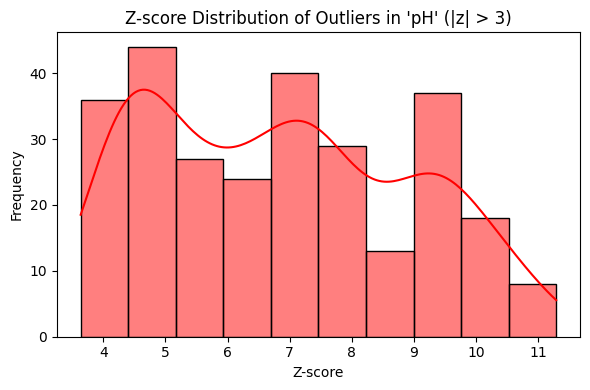

Outliers detected in 'Conductivity': 402


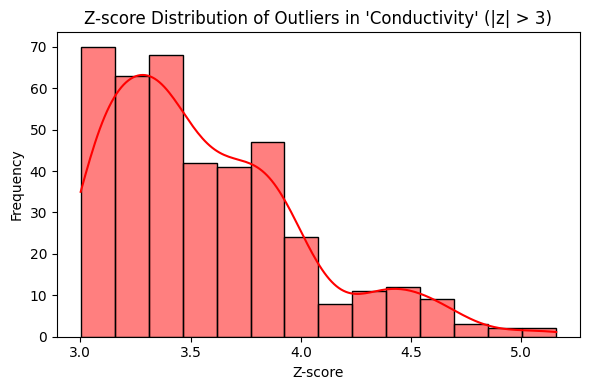

Outliers detected in 'Dissolved Oxygen': 304


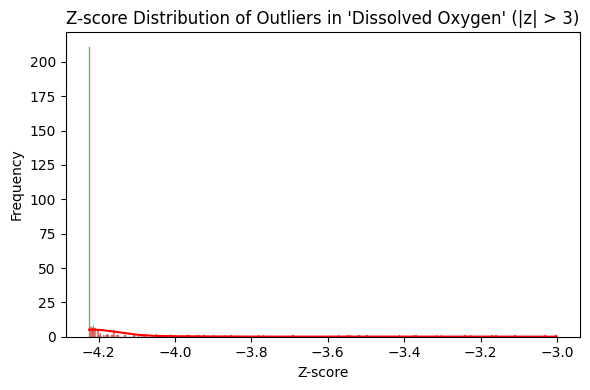

/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


Outliers detected in 'Turbidity': 0
Outliers detected in 'Stage': 91


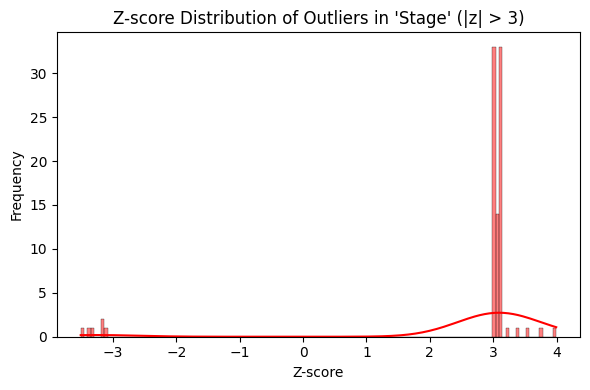

Outliers detected in 'Longitude (x)': 0
Outliers detected in 'Latitude (y)': 0
Outliers detected in 'Climate ID': 0
Outliers detected in 'Year': 0
Outliers detected in 'Month': 0
Outliers detected in 'Day': 0
Outliers detected in 'Max Temp (°C)': 6


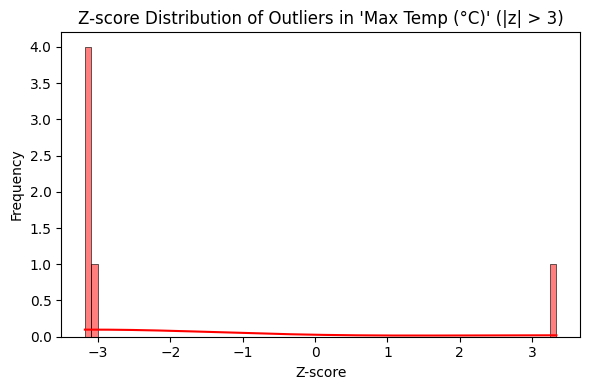

Outliers detected in 'Min Temp (°C)': 7


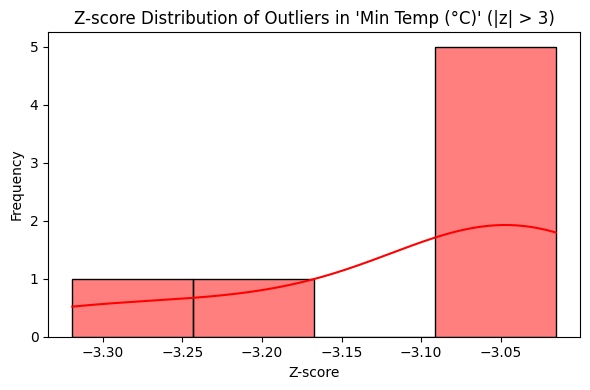

Outliers detected in 'Mean Temp (°C)': 4


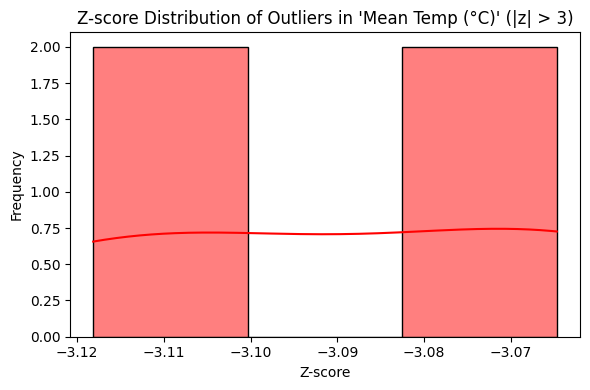

Outliers detected in 'Heat Deg Days (°C)': 8


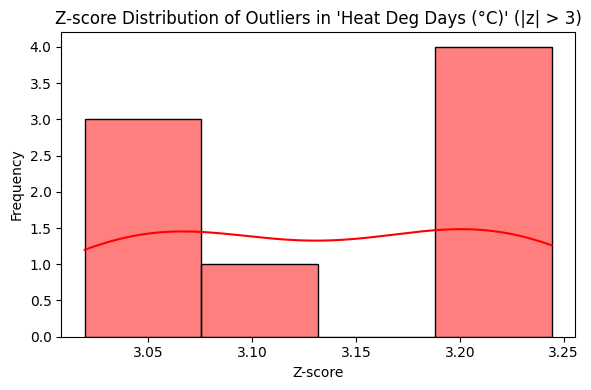

Outliers detected in 'Cool Deg Days (°C)': 620


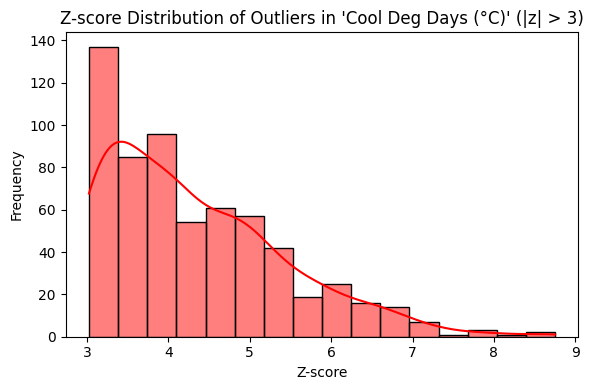

Outliers detected in 'Total Rain (mm)': 431


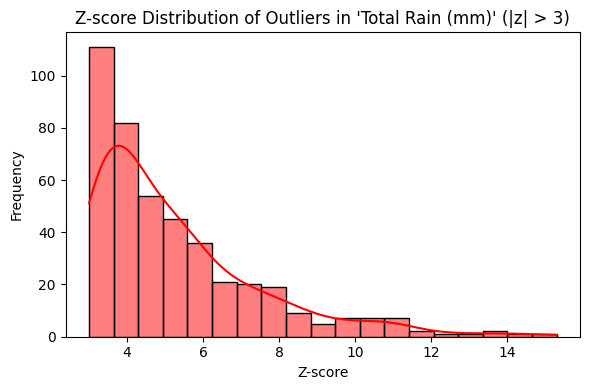

Outliers detected in 'Total Snow (cm)': 255


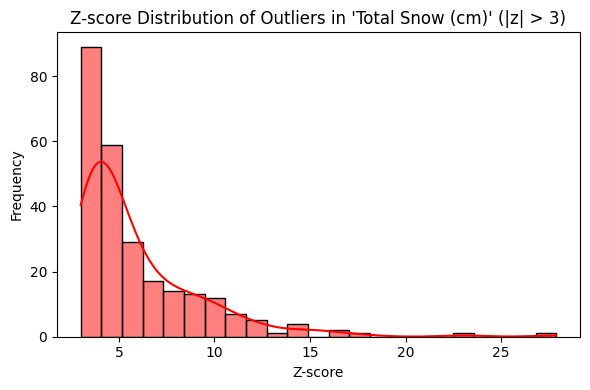

Outliers detected in 'Total Precip (mm)': 454


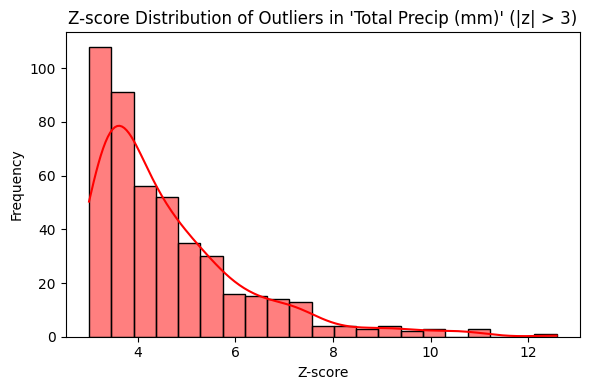

Outliers detected in 'Snow on Grnd (cm)': 478


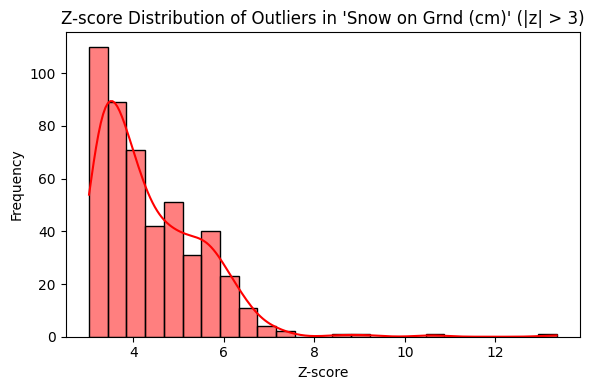

Outliers detected in 'Dir of Max Gust (10s deg)': 170


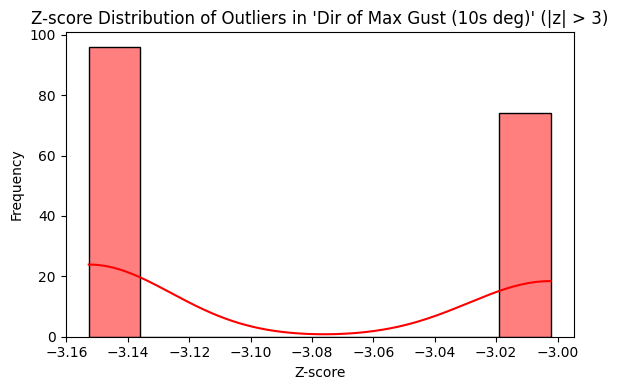

Outliers detected in 'Spd of Max Gust (km/h)': 295


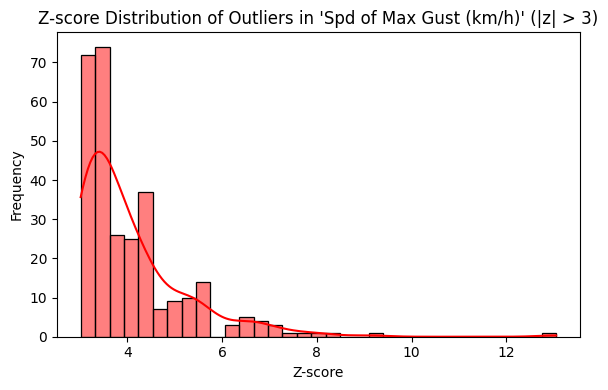


Summary of outliers (per column) marked as NaN:
Temperature: 0
pH: 276
Conductivity: 402
Dissolved Oxygen: 304
Turbidity: 0
Stage: 91
Longitude (x): 0
Latitude (y): 0
Climate ID: 0
Year: 0
Month: 0
Day: 0
Max Temp (°C): 6
Min Temp (°C): 7
Mean Temp (°C): 4
Heat Deg Days (°C): 8
Cool Deg Days (°C): 620
Total Rain (mm): 431
Total Snow (cm): 255
Total Precip (mm): 454
Snow on Grnd (cm): 478
Dir of Max Gust (10s deg): 170
Spd of Max Gust (km/h): 295


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:424: RuntimeWarning: overflow encountered in multiply
  distances = -2 * safe_sparse_dot(X, Y.T, dense_output=True)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:426: RuntimeWarning: invalid value encountered in add
  distances += YY
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:556: RuntimeWarning: overflow encountered in multiply
  YY = Y * Y



Missing values in numeric columns AFTER KNN re-imputation:
Temperature                  0
pH                           0
Conductivity                 0
Dissolved Oxygen             0
Turbidity                    0
Stage                        0
Longitude (x)                0
Latitude (y)                 0
Climate ID                   0
Year                         0
Month                        0
Day                          0
Max Temp (°C)                0
Min Temp (°C)                0
Mean Temp (°C)               0
Heat Deg Days (°C)           0
Cool Deg Days (°C)           0
Total Rain (mm)              0
Total Snow (cm)              0
Total Precip (mm)            0
Snow on Grnd (cm)            0
Dir of Max Gust (10s deg)    0
Spd of Max Gust (km/h)       0
dtype: int64


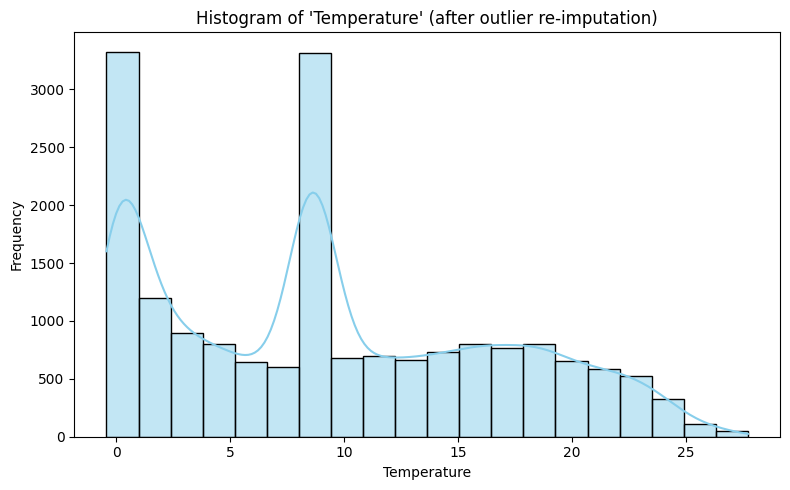

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 18160.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk test for 'Temperature': statistic = 0.935, p-value = 0.000
Kolmogorov-Smirnov test for 'Temperature': statistic = 0.114, p-value = 0.000
Anderson-Darling test for 'Temperature': statistic = 332.918
  At 15.0% significance level, critical value: 0.576
  At 10.0% significance level, critical value: 0.656
  At 5.0% significance level, critical value: 0.787
  At 2.5% significance level, critical value: 0.918
  At 1.0% significance level, critical value: 1.092


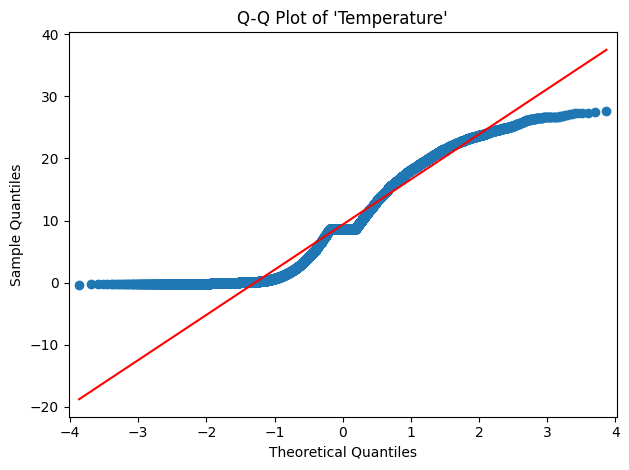

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1120: RuntimeWarning: overflow encountered in square
  temp **= 2
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: overflow encountered in square
  upper_bound = n_samples * eps * var + (n_samples * mean * eps) ** 2



Data normalized using z-score normalization.
Mean and std of 'Temperature' after normalization: -0.00, 1.00

Processed dataset saved to: /content/drive/MyDrive/Data_Mining/processed_data_knn_outlier.csv


In [ ]:

# 1. Install Required Packages

!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl statsmodels --quiet


# 2. Mount Google Drive and Load the Merged Dataset

from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For normality tests and Q-Q plots
from scipy.stats import zscore, shapiro, kstest, anderson
import statsmodels.api as sm

# For re-imputation using KNN
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the merged dataset
data_path = '/content/drive/MyDrive/Data_Mining/merged_no_nan.csv'
df = pd.read_csv(data_path)
print("Loaded merged dataset shape:", df.shape)


# 3. Identify Numeric Columns and Initial Imputation

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns:", numeric_cols)

# If there are any initial missing values, impute them with KNNImputer
if df[numeric_cols].isnull().sum().sum() > 0:
    print("Initial missing values found. Applying initial KNN imputation...")
    knn_imputer_initial = KNNImputer(n_neighbors=5)
    df[numeric_cols] = knn_imputer_initial.fit_transform(df[numeric_cols])

print("\nMissing values in numeric columns AFTER initial imputation:")
print(df[numeric_cols].isnull().sum())


# 4. Outlier Detection Using Z-Score and Marking Outliers as NaN

threshold = 3
df_out = df.copy()
outlier_counts = {}

for col in numeric_cols:
    col_vals = df_out[col]
    col_z = (col_vals - col_vals.mean()) / col_vals.std(ddof=0)
    n_outliers = (col_z.abs() > threshold).sum()
    outlier_counts[col] = n_outliers
    print(f"Outliers detected in '{col}': {n_outliers}")

    # Plot the distribution of z-scores for outliers
    if n_outliers > 0:
        plt.figure(figsize=(6,4))
        sns.histplot(col_z[col_z.abs() > threshold], kde=True, color='red')
        plt.title(f"Z-score Distribution of Outliers in '{col}' (|z| > {threshold})")
        plt.xlabel("Z-score")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    # Mark outlier values as NaN (to be replaced)
    df_out.loc[col_z.abs() > threshold, col] = np.nan

print("\nSummary of outliers (per column) marked as NaN:")
for col, count in outlier_counts.items():
    print(f"{col}: {count}")


# 5. Re-Imputation Using KNNImputer

# Instead of leaving outlier values as NaN, use KNNImputer to replace them.
knn_imputer = KNNImputer(n_neighbors=5)
df_out[numeric_cols] = knn_imputer.fit_transform(df_out[numeric_cols])
print("\nMissing values in numeric columns AFTER KNN re-imputation:")
print(df_out[numeric_cols].isnull().sum())


# 6. Normality Testing on a Representative Column Using Multiple Methods

rep_col = "Temperature" if "Temperature" in numeric_cols else numeric_cols[0]
rep_data = df_out[rep_col].dropna()

plt.figure(figsize=(8,5))
sns.histplot(rep_data, bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title(f"Histogram of '{rep_col}' (after outlier re-imputation)")
plt.xlabel(rep_col)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Shapiro-Wilk Test
stat_sw, p_sw = shapiro(rep_data)
print(f"Shapiro-Wilk test for '{rep_col}': statistic = {stat_sw:.3f}, p-value = {p_sw:.3f}")

# Kolmogorov-Smirnov Test
mean_rep = rep_data.mean()
std_rep = rep_data.std(ddof=0)
stat_ks, p_ks = kstest(rep_data, 'norm', args=(mean_rep, std_rep))
print(f"Kolmogorov-Smirnov test for '{rep_col}': statistic = {stat_ks:.3f}, p-value = {p_ks:.3f}")

# Anderson-Darling Test
result_ad = anderson(rep_data, dist='norm')
print(f"Anderson-Darling test for '{rep_col}': statistic = {result_ad.statistic:.3f}")
for i, (crit, sig) in enumerate(zip(result_ad.critical_values, result_ad.significance_level)):
    print(f"  At {sig}% significance level, critical value: {crit:.3f}")

# Q-Q Plot using statsmodels
sm.qqplot(rep_data, line='s')
plt.title(f"Q-Q Plot of '{rep_col}'")
plt.tight_layout()
plt.show()


# 7. Normalize Data Using Z-Score Normalization

scaler = StandardScaler()
df_out[numeric_cols] = scaler.fit_transform(df_out[numeric_cols])
print("\nData normalized using z-score normalization.")
print(f"Mean and std of '{rep_col}' after normalization: {df_out[rep_col].mean():.2f}, {df_out[rep_col].std(ddof=0):.2f}")
output_path = '/content/drive/MyDrive/Data_Mining/processed_data_knn_outlier.csv'
df_out.to_csv(output_path, index=False)
print("\nProcessed dataset saved to:", output_path)


# Dimensionality Reduction using PCA

In [ ]:
# 1. Install Required Packages

!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl statsmodels fancyimpute --quiet

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.9 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-5-c2924db5621f>:25: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Loaded cleaned dataset shape: (18160, 38)

Selected features for PCA:
['Temperature', 'pH', 'Conductivity', 'Dissolved Oxygen', 'Turbidity', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)', 'Spd of Max Gust (km/h)']

Missing values in selected features before IterativeSVD:
Temperature                   0
pH                            0
Conductivity                  0
Dissolved Oxygen              0
Turbidity                 18160
Max Temp (°C)                 0
Min Temp (°C)                 0
Mean Temp (°C)                0
Heat Deg Days (°C)            0
Cool Deg Days (°C)            0
Total Rain (mm)               0
Total Snow (cm)               0
Total Precip (mm)             0
Snow on Grnd (cm)             0
Spd of Max Gust (km/h)        0
dtype: int64
[IterativeSVD] Iter 1: observed MAE=0.480813
[IterativeSVD] Iter 2: observed MAE=0.404729
[IterativeSVD] I

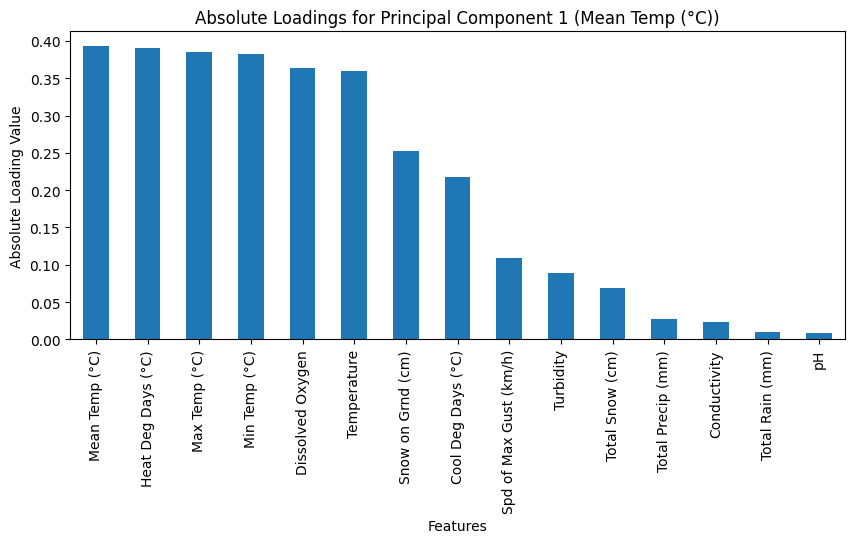

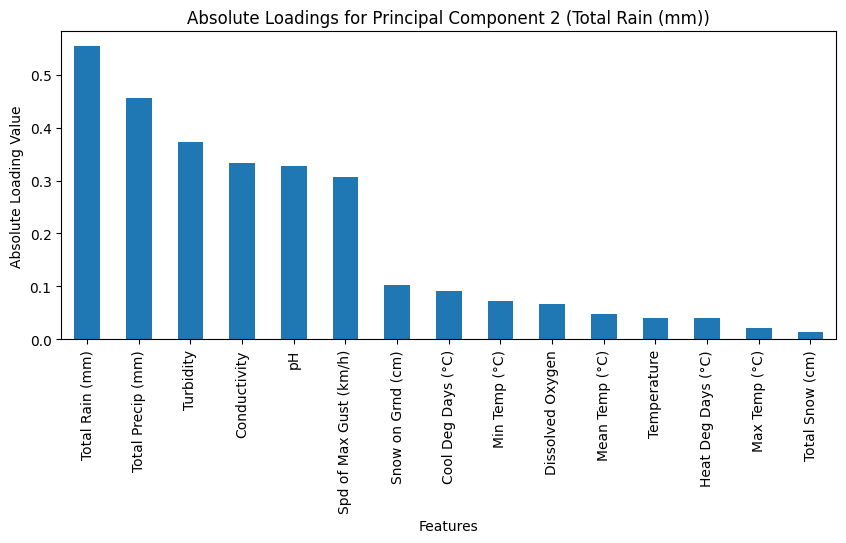

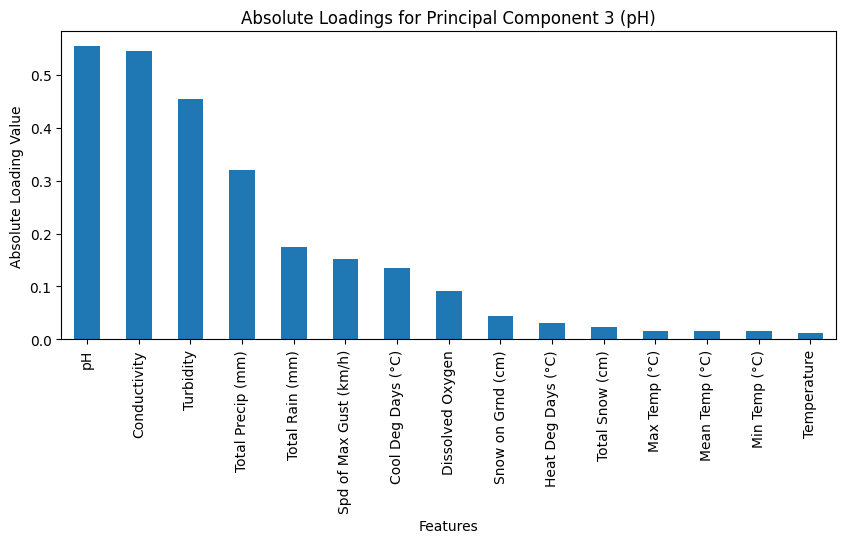

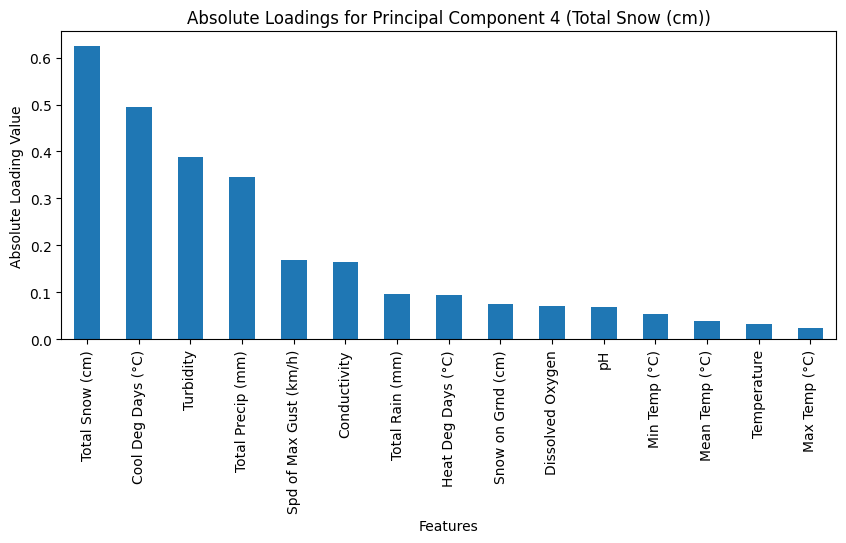

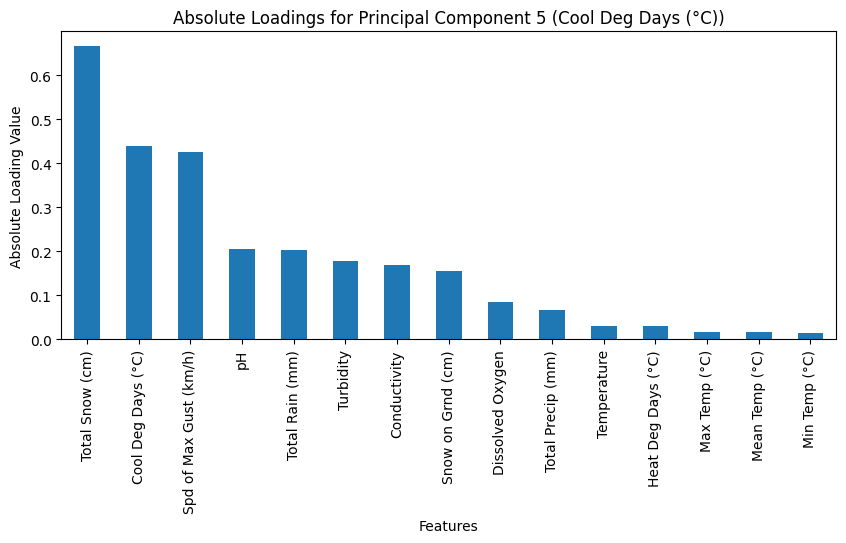

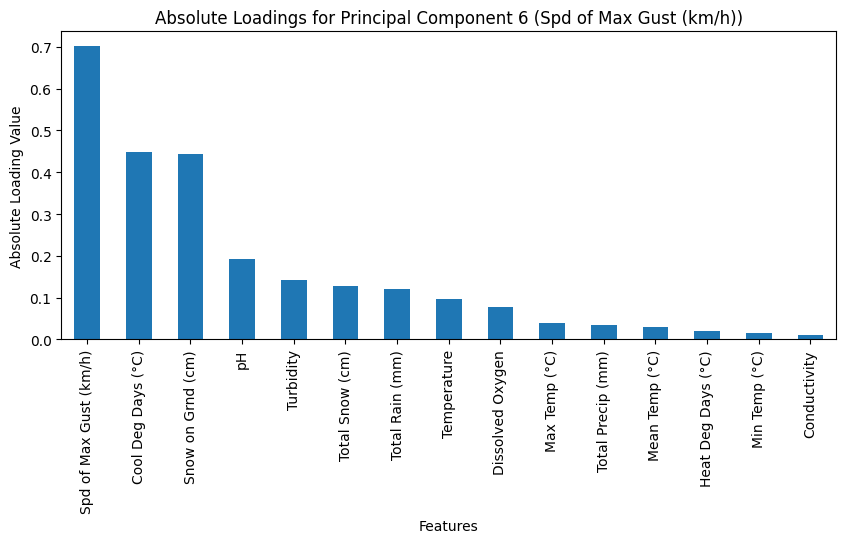

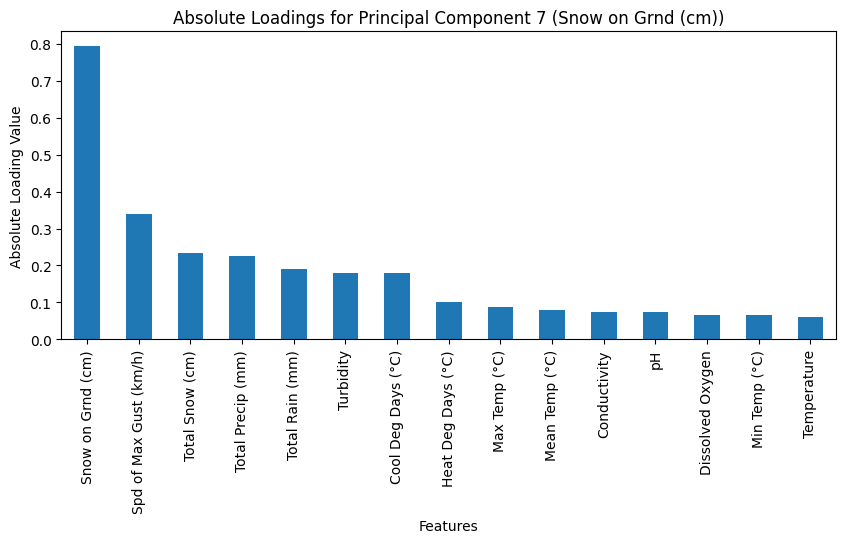

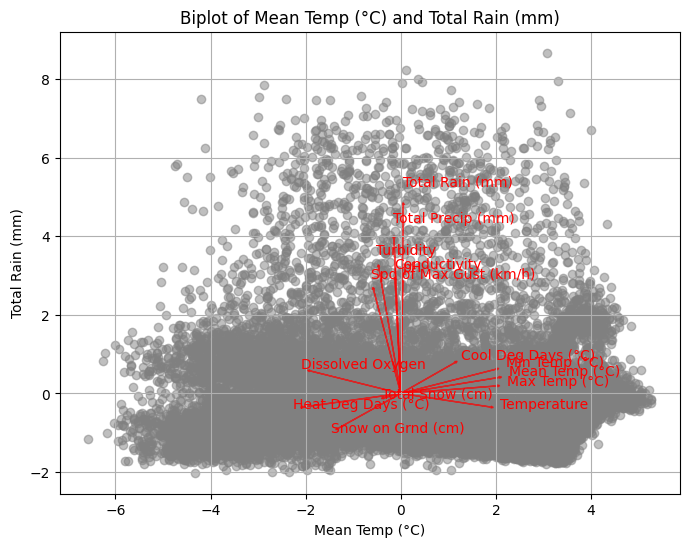


Correlation between original features and PCA components:
                        Mean Temp (°C)  Mean Temp (°C)  Total Rain (mm)  \
Temperature                   0.824429    8.982030e-01        -0.005627   
pH                            0.065423    2.033383e-02         0.205458   
pH                            0.022321   -3.691202e-16        -0.240281   
Conductivity                 -0.016672   -5.701262e-02         0.171180   
Dissolved Oxygen             -0.838669   -9.063091e-01        -0.008315   
Turbidity                    -0.216697   -2.203687e-01         0.527649   
Max Temp (°C)                 0.977674    9.617960e-01         0.052931   
Min Temp (°C)                 0.972492    9.538635e-01         0.107304   
Mean Temp (°C)                1.000000    9.806464e-01         0.080860   
Mean Temp (°C)                0.980646    1.000000e+00         0.024189   
Heat Deg Days (°C)           -0.994700   -9.728618e-01        -0.089177   
Cool Deg Days (°C)            0.522944   

In [ ]:
# 2. Mount Google Drive and Load the Cleaned Dataset

from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For matrix completion
from fancyimpute import IterativeSVD

# For scaling and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# 3. Load the Cleaned Dataset

data_path = '/content/drive/MyDrive/Data_Mining/processed_data_knn_outlier.csv'
df = pd.read_csv(data_path)
print("Loaded cleaned dataset shape:", df.shape)


# 4. Select Only Useful Features for PCA
useful_features = [
    'Temperature', 'pH', 'Conductivity', 'Dissolved Oxygen', 'Turbidity',
    'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 'Heat Deg Days (°C)',
    'Cool Deg Days (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
    'Snow on Grnd (cm)', 'Spd of Max Gust (km/h)'
]

# Retain only those that exist in the dataframe.
selected_features = [col for col in useful_features if col in df.columns]
print("\nSelected features for PCA:")
print(selected_features)

# Subset the data to these columns
df_selected = df[selected_features].copy()


# 5. Imputation with IterativeSVD on Selected Features
# Check for missing values:
print("\nMissing values in selected features before IterativeSVD:")
print(df_selected.isnull().sum())

# Use IterativeSVD from fancyimpute
svd_imputer = IterativeSVD(rank=7, convergence_threshold=0.001)
X = df_selected.values
X_completed = svd_imputer.fit_transform(X)

# Verify no NaNs remain
if np.isnan(X_completed).sum() == 0:
    print("\nMatrix completion successful; no NaNs remain in selected features.")
else:
    print("\nSome NaNs still remain.")

# Replace the selected features in the DataFrame with the completed matrix.
df_selected = pd.DataFrame(X_completed, columns=selected_features)


# 6. Normalize Data Using Z-Score

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected)
print("\nData has been scaled. Shape:", X_scaled.shape)


# 7. Perform PCA with 7 Components
n_components = 7
pca = PCA(n_components=n_components)
pca_data = pca.fit_transform(X_scaled)

# Get variance ratios and print them.
explained_variance = pca.explained_variance_ratio_
print("\nExplained variance ratios for the 7 components:")
for i, ratio in enumerate(explained_variance, start=1):
    print(f"Component {i}: {ratio:.3f}")


# 8. Determine Descriptive Names for PCA Components
used_features = set()
descriptive_names = []
for i in range(n_components):
    loadings = np.abs(pca.components_[i])
    # Create a list of (feature, loading) pairs sorted descending by loading
    feature_loadings = sorted(list(zip(selected_features, loadings)), key=lambda x: x[1], reverse=True)
    chosen_feature = None
    for feat, ld in feature_loadings:
        if feat not in used_features:
            chosen_feature = feat
            used_features.add(feat)
            break
    # If all features are already used, fall back to the top feature with a suffix.
    if chosen_feature is None:
        chosen_feature = feature_loadings[0][0] + f"_{i+1}"
    descriptive_names.append(chosen_feature)

print("\nDescriptive PCA component names (based on top loadings):")
for i, name in enumerate(descriptive_names, start=1):
    print(f"Component {i}: {name}")

# Create descriptive PCA column names.
pca_col_names = [f"{name}" for name in descriptive_names]


# 9. Save the PCA-Processed Data to Google Drive (Only Location, Date + 7 PCA Columns)
non_numeric = df.iloc[:, :2]  # keep only the first two columns - Location and Date

# Create a DataFrame for the PCA-transformed data using the descriptive column names.
pca_df = pd.DataFrame(pca_data, columns=pca_col_names)

# Concatenate the two-column DataFrame with the PCA components.
final_df = pd.concat([non_numeric.reset_index(drop=True), pca_df], axis=1)

output_path = '/content/drive/MyDrive/Data_Mining/processed_data_pca.csv'
final_df.to_csv(output_path, index=False)
print("\nPCA-processed dataset saved to:", output_path)


# 10. Analyze and Visualize PCA Loadings

# Create a DataFrame for PCA loadings
loadings_df = pd.DataFrame(pca.components_.T, index=selected_features, columns=[f'PC{i+1}' for i in range(n_components)])
print("\nPCA Loadings Matrix:")
print(loadings_df)

# Plot absolute loadings for each principal component to see how dominant each feature is
for i in range(n_components):
    plt.figure(figsize=(10, 4))
    sorted_loadings = loadings_df.iloc[:, i].abs().sort_values(ascending=False)
    sorted_loadings.plot(kind='bar')
    plt.title(f'Absolute Loadings for Principal Component {i+1} ({descriptive_names[i]})')
    plt.ylabel('Absolute Loading Value')
    plt.xlabel('Features')
    plt.show()


# 11. Create a Biplot for the First Two Principal Components with Descriptive Axis Labels
def biplot(score, coeff, labels=None, xlabel='PC1', ylabel='PC2'):
    xs = score[:, 0]
    ys = score[:, 1]
    plt.figure(figsize=(8, 6))
    plt.scatter(xs, ys, c='grey', alpha=0.5)

    scale_x = max(xs)
    scale_y = max(ys)
    for i in range(coeff.shape[0]):
        plt.arrow(0, 0, coeff[i, 0] * scale_x, coeff[i, 1] * scale_y,
                  color='red', alpha=0.7, head_width=0.05, head_length=0.05)
        if labels is None:
            plt.text(coeff[i, 0] * scale_x * 1.1, coeff[i, 1] * scale_y * 1.1, f"Var{i+1}", color='red')
        else:
            plt.text(coeff[i, 0] * scale_x * 1.1, coeff[i, 1] * scale_y * 1.1, labels[i], color='red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"Biplot of {xlabel} and {ylabel}")
    plt.grid()
    plt.show()


biplot(pca_data, pca.components_.T, labels=selected_features, xlabel=descriptive_names[0], ylabel=descriptive_names[1])


# 12. Correlation between Original Features and PCA Components with Descriptive Names

# Create a DataFrame for the PCA components using the descriptive names determined earlier.
pc_df = pd.DataFrame(pca_data, columns=descriptive_names)

# Concatenate the original (imputed & scaled) data and the PCA components.
combined_df = pd.concat([pd.DataFrame(X_scaled, columns=selected_features), pc_df], axis=1)

# Compute and display the correlation matrix between original features and PCA components.
corr_matrix = combined_df.corr()
print("\nCorrelation between original features and PCA components:")
print(corr_matrix.loc[selected_features, descriptive_names])



# Extended PCA Analysis: Correlation and Pairwise Visualization

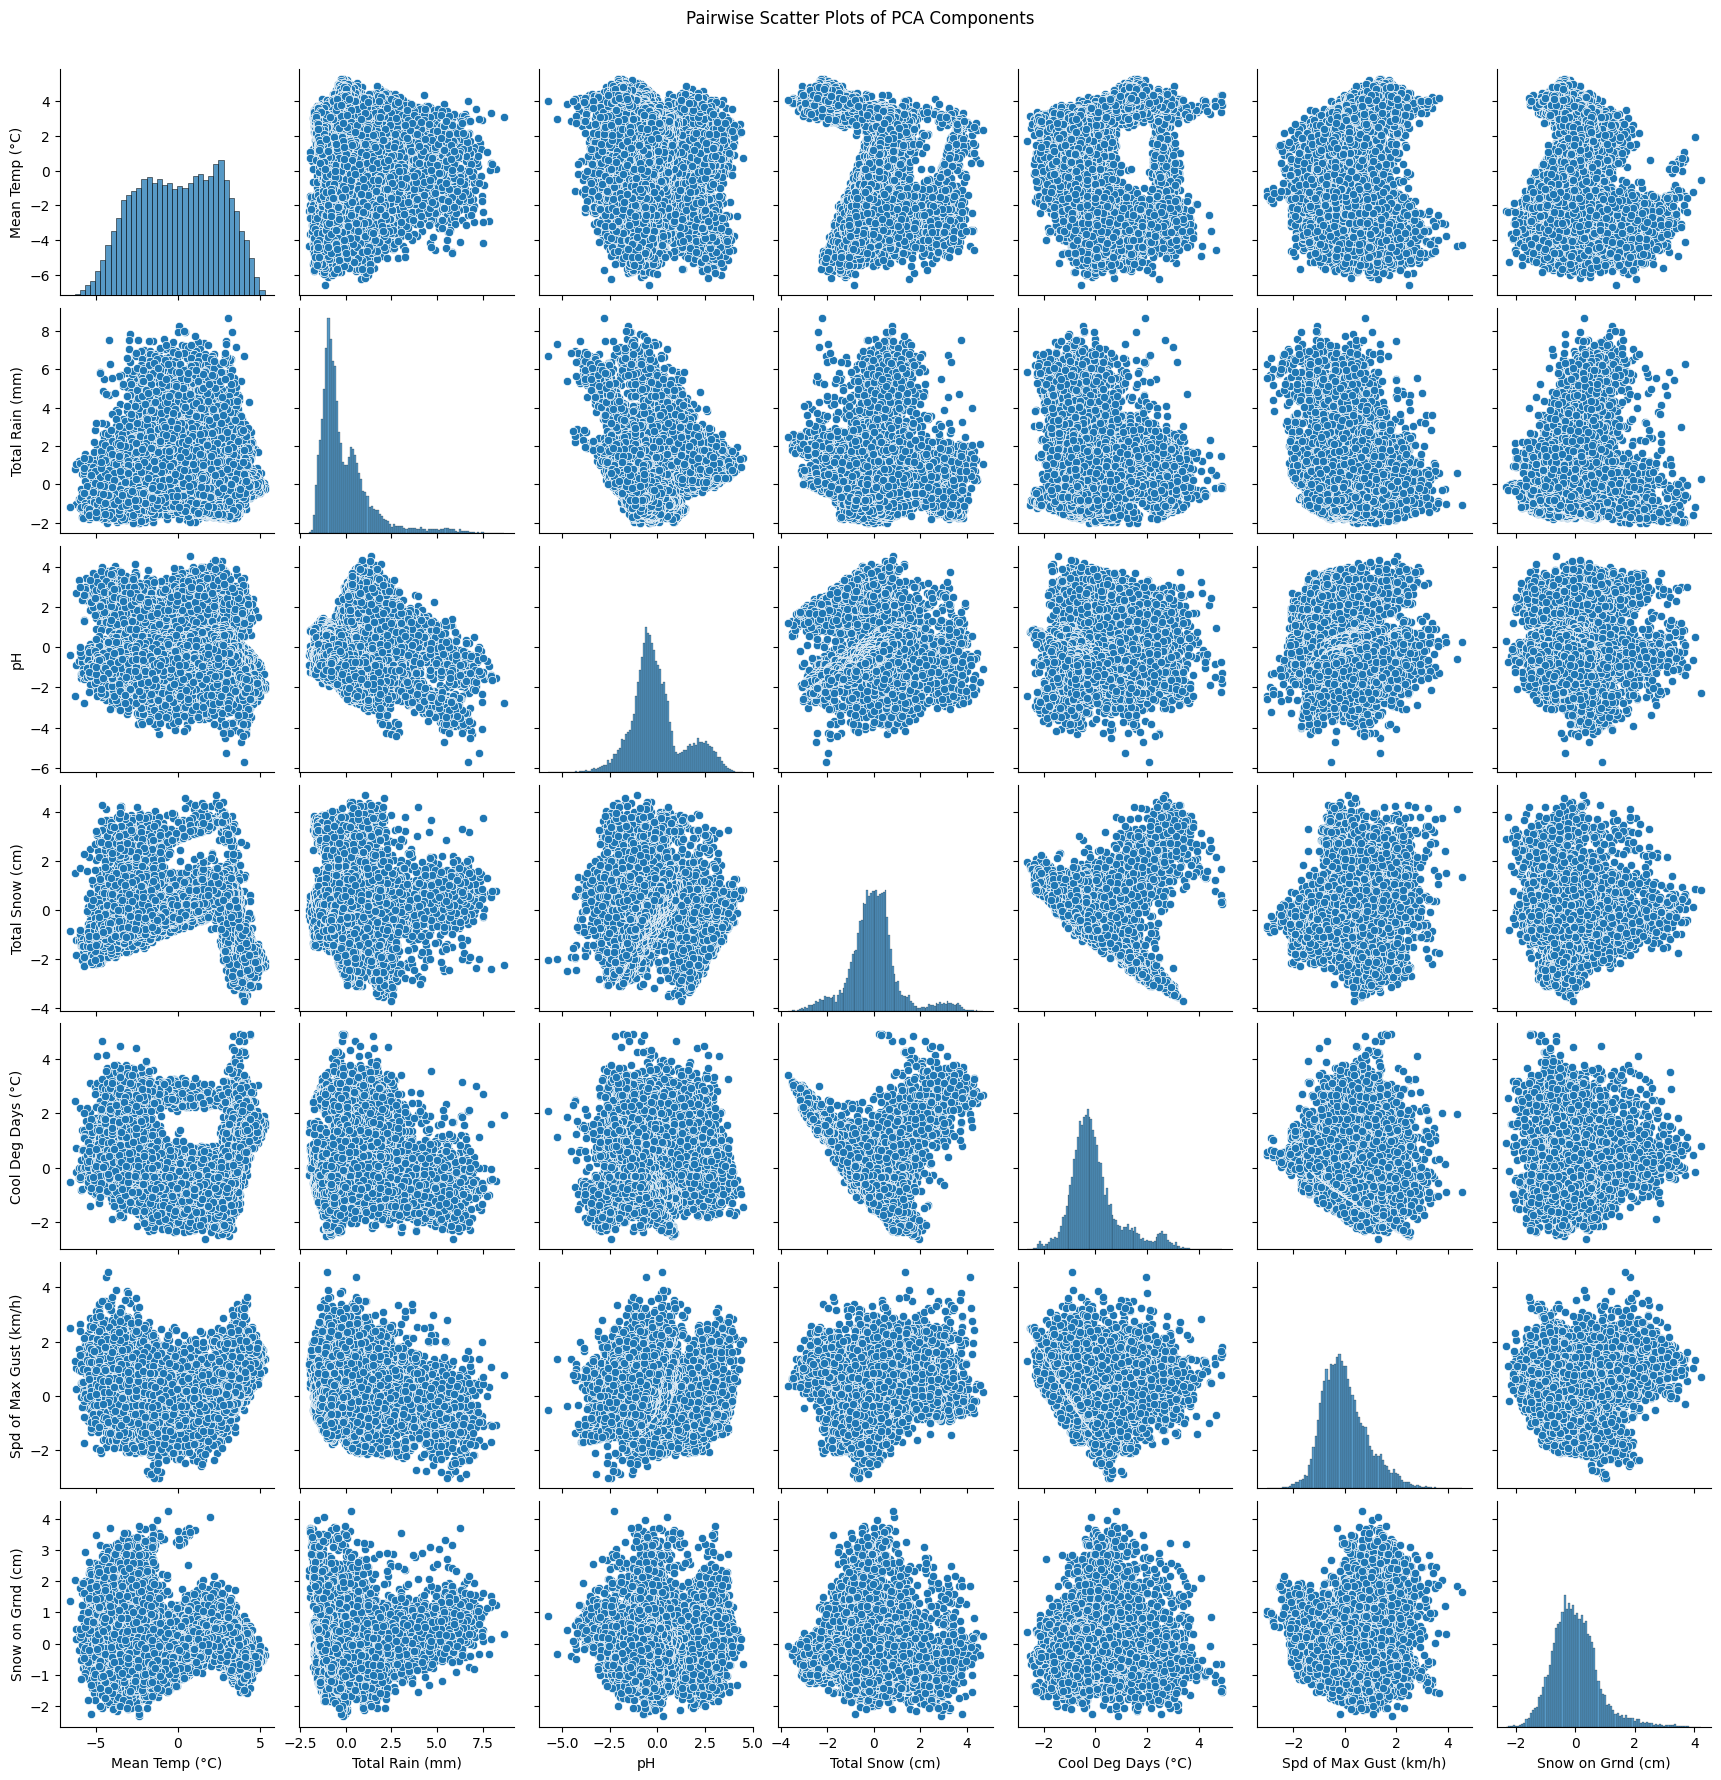

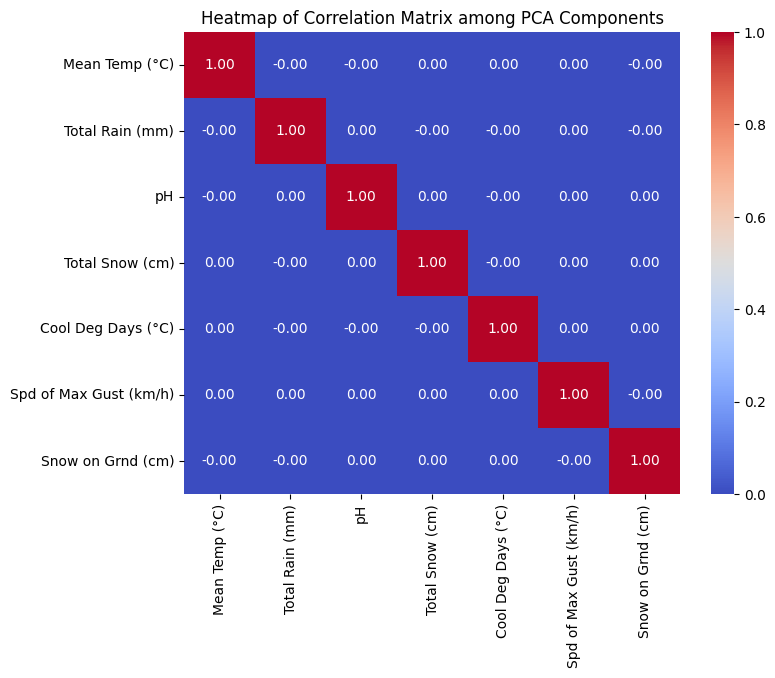

High correlation pairs among PCA components (abs(correlation) > 0.7):


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# 1. Pairwise Scatter Matrix of PCA Components
sns.pairplot(pc_df)
plt.suptitle("Pairwise Scatter Plots of PCA Components", y=1.02)
plt.show()


# 2. Heatmap of the Correlation Matrix among PCA Components
corr_components = pc_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_components, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap of Correlation Matrix among PCA Components")
plt.show()


# 3. Identify and Plot High-Correlation Pairs

threshold = 0.7
high_corr_pairs = []
for i in range(len(descriptive_names)):
    for j in range(i+1, len(descriptive_names)):
        corr_val = corr_components.iloc[i, j]
        if abs(corr_val) > threshold:
            high_corr_pairs.append((descriptive_names[i], descriptive_names[j], corr_val))

print("High correlation pairs among PCA components (abs(correlation) > 0.7):")
for comp1, comp2, corr_val in high_corr_pairs:
    print(f"{comp1} vs {comp2}: {corr_val:.2f}")

# Plot scatter plots for these highly correlated pairs
for comp1, comp2, corr_val in high_corr_pairs:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=pc_df[comp1], y=pc_df[comp2])
    plt.title(f"Scatter Plot: {comp1} vs {comp2}\nCorrelation: {corr_val:.2f}")
    plt.xlabel(comp1)
    plt.ylabel(comp2)
    plt.show()


P-values for pairwise correlations between PCA components:
                        Mean Temp (°C)  Total Rain (mm)   pH  Total Snow (cm)  \
Mean Temp (°C)                     0.0              1.0  1.0              1.0   
Total Rain (mm)                    1.0              0.0  1.0              1.0   
pH                                 1.0              1.0  0.0              1.0   
Total Snow (cm)                    1.0              1.0  1.0              0.0   
Cool Deg Days (°C)                 1.0              1.0  1.0              1.0   
Spd of Max Gust (km/h)             1.0              1.0  1.0              1.0   
Snow on Grnd (cm)                  1.0              1.0  1.0              1.0   

                        Cool Deg Days (°C)  Spd of Max Gust (km/h)  \
Mean Temp (°C)                         1.0                     1.0   
Total Rain (mm)                        1.0                     1.0   
pH                                     1.0                     1.0   
Total Snow (

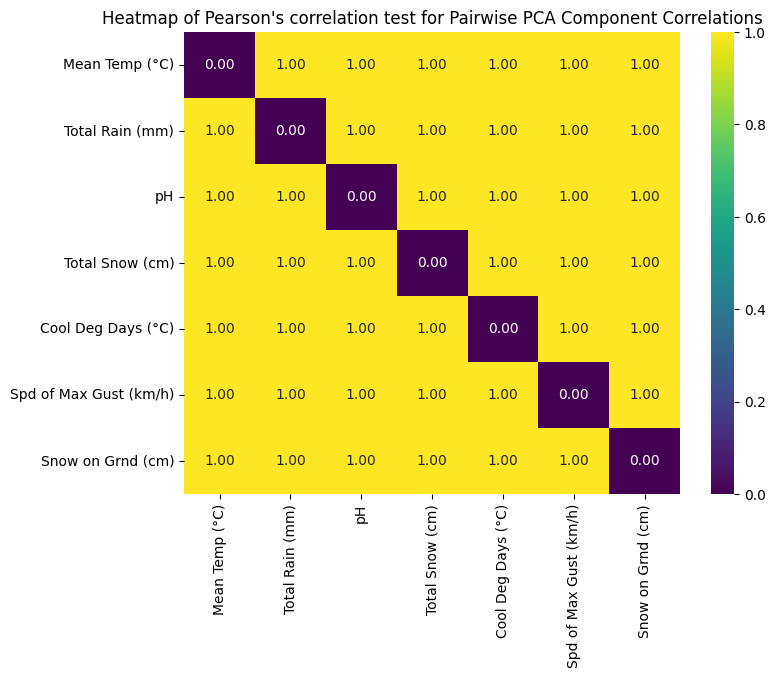

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


# 1. Correlation Analysis on PCA Components with Significance Testing
corr_components = pc_df.corr()

# Create a DataFrame to hold p-values for pairwise correlations among PCA components
p_values = pd.DataFrame(np.zeros(corr_components.shape), index=pc_df.columns, columns=pc_df.columns)

for i in range(len(pc_df.columns)):
    for j in range(len(pc_df.columns)):
        corr, p = pearsonr(pc_df.iloc[:, i], pc_df.iloc[:, j])
        p_values.iloc[i, j] = p

print("P-values for pairwise correlations between PCA components:")
print(p_values)

# Visualize p-values as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(p_values.round(2), annot=True, cmap='viridis', fmt=".2f")
plt.title("Heatmap of Pearson's correlation test for Pairwise PCA Component Correlations")
plt.show()


# Feature Engineering - Rolling Averages + Lagged Features

In [ ]:
# 1. Install Required Packages

!pip install pandas numpy matplotlib seaborn --quiet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded dataset shape: (18160, 9)
Dataset indexed by Date.

Features used for rolling/lagged engineering: ['Mean Temp (°C)', 'Conductivity', 'Total Precip (mm)', 'Turbidity', 'Total Snow (cm)', 'Cool Deg Days (°C)', 'Spd of Max Gust (km/h)']

New feature columns:
Index(['Location', 'Mean Temp (°C)', 'Conductivity', 'Total Precip (mm)',
       'Turbidity', 'Total Snow (cm)', 'Cool Deg Days (°C)',
       'Spd of Max Gust (km/h)', 'Mean Temp (°C)_roll7', 'Conductivity_roll7',
       'Total Precip (mm)_roll7', 'Turbidity_roll7', 'Total Snow (cm)_roll7',
       'Cool Deg Days (°C)_roll7', 'Spd of Max Gust (km/h)_roll7',
       'Mean Temp (°C)_lag1', 'Mean Temp (°C)_lag3', 'Mean Temp (°C)_lag7',
       'Mean Temp (°C)_lag14', 'Mean Temp (°C)_lag30', 'Conductivity_lag1',
       'Conductivity_lag3', 'Conductivity_lag7', 'Conductivity_lag14',
       'Conductivity_lag30

Location  Mean Temp (°C)  Conductivity  Total Precip (mm)  \
Date                                                                    
2002-06-12  Margaree        0.058949      1.523907          -1.534660   
2002-06-13  Margaree        0.348318      1.705031          -1.611322   
2002-06-14  Margaree        0.441319      1.783094          -1.732714   
2002-06-15  Margaree        0.082465      1.528965          -1.737231   
2002-06-16  Margaree        0.060742      3.669775           0.614938   
2002-06-17  Margaree        0.444439      1.643559          -1.896536   
2002-06-18  Margaree        0.411510      1.878601          -1.904265   
2002-06-19  Margaree        0.573360      2.087415          -1.976496   
2002-06-20  Margaree        1.490095      1.643346          -2.385117   
2002-06-21  Margaree        2.424964      2.261385          -2.325808   
2002-06-22  Margaree        1.288097      2.634499          -2.257278   
2002-06-23  Margaree        1.057352      2.107839          -2.441150   
2002-06-24  Margaree        1.141037      5.936321           2.930541   
2002-06-25  Margaree        0.617710      2.211421          -1.308268   
2002-06-26  Margaree        2.130409      1.060692          -2.058084   

            Turbidity  Total Snow (cm)  Cool Deg Days (°C)  \
Date                                                         
2002-06-12  -0.510821        -0.117290           -0.468150   
2002-06-13  -0.325996        -0.130281           -0.482147   
2002-06-14  -0.264956        -0.072886           -0.523000   
2002-06-15  -0.548958         0.212655           -0.696804   
2002-06-16  -0.023388        -0.488413           -0.390837   
2002-06-17  -0.371741         0.203515           -0.712770   
2002-06-18  -0.319462         0.071882           -0.596121   
2002-06-19  -0.159447        -0.010694           -0.547549   
2002-06-20   0.176066         0.588759           -1.119903   
2002-06-21   0.173005         0.332465            0.285055   
2002-06-22   0.360755        -0.081885           -0.556145   
2002-06-23   0.075502         0.350485           -0.847552   
2002-06-24   1.246801        -0.733936           -0.476662   
2002-06-25  -0.040600        -0.619977           -0.175398   
2002-06-26   0.337166         0.646912           -1.191554   

            Spd of Max Gust (km/h)  Mean Temp (°C)_roll7  Conductivity_roll7  \
Date                                                                           
2002-06-12                0.522193              0.058949            1.523907   
2002-06-13                0.723683              0.203634            1.614469   
2002-06-14                0.661396              0.282862            1.670677   
2002-06-15               -0.394122              0.232763            1.635249   
2002-06-16               -0.422680              0.198359            2.042154   
2002-06-17               -0.041694              0.239372            1.975722   
2002-06-18                0.349510              0.263963            1.961847   
2002-06-19                0.695997              0.337450            2.042349   
2002-06-20               -0.539075              0.500561            2.033536   
2002-06-21                0.352805              0.783939            2.101864   
2002-06-22                1.351320              0.956172            2.259797   
2002-06-23                0.048448              1.098545            2.036663   
2002-06-24               -0.961156              1.198059            2.649915   
2002-06-25                2.137591              1.227516            2.697461   
2002-06-26               -0.740368              1.449952            2.550786   

            ...  Cool Deg Days (°C)_lag1  Cool Deg Days (°C)_lag3  \
Date        ...                                                     
2002-06-12  ...                      NaN                      NaN   
2002-06-13  ...                -0.468150                      NaN   
2002-06-14  ...                -0.482147                      NaN   
2002-06-1

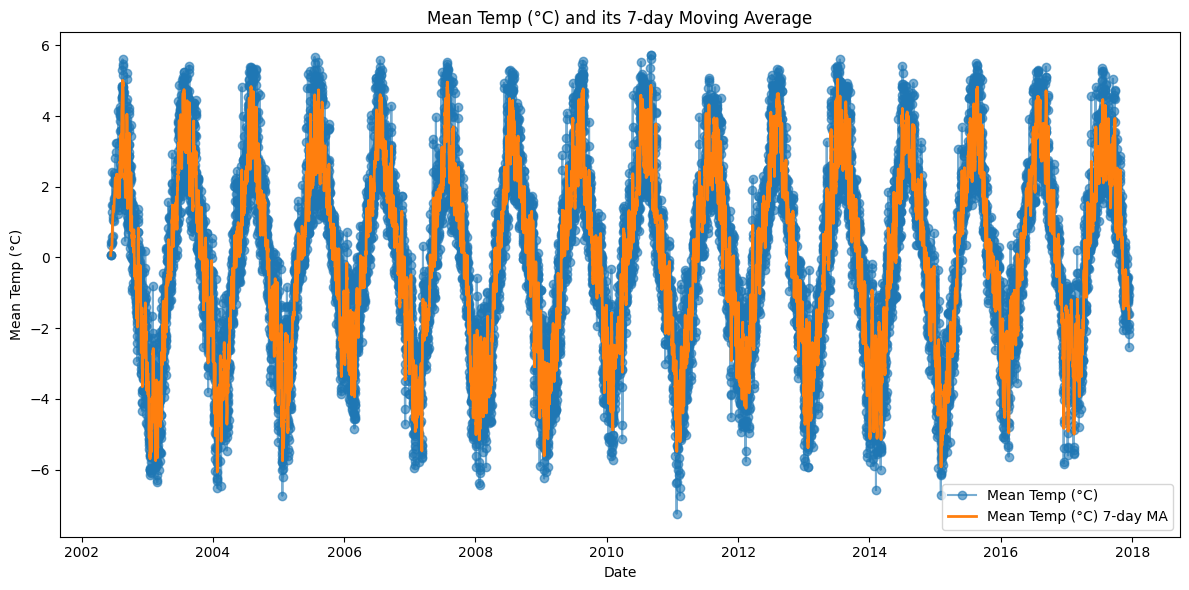

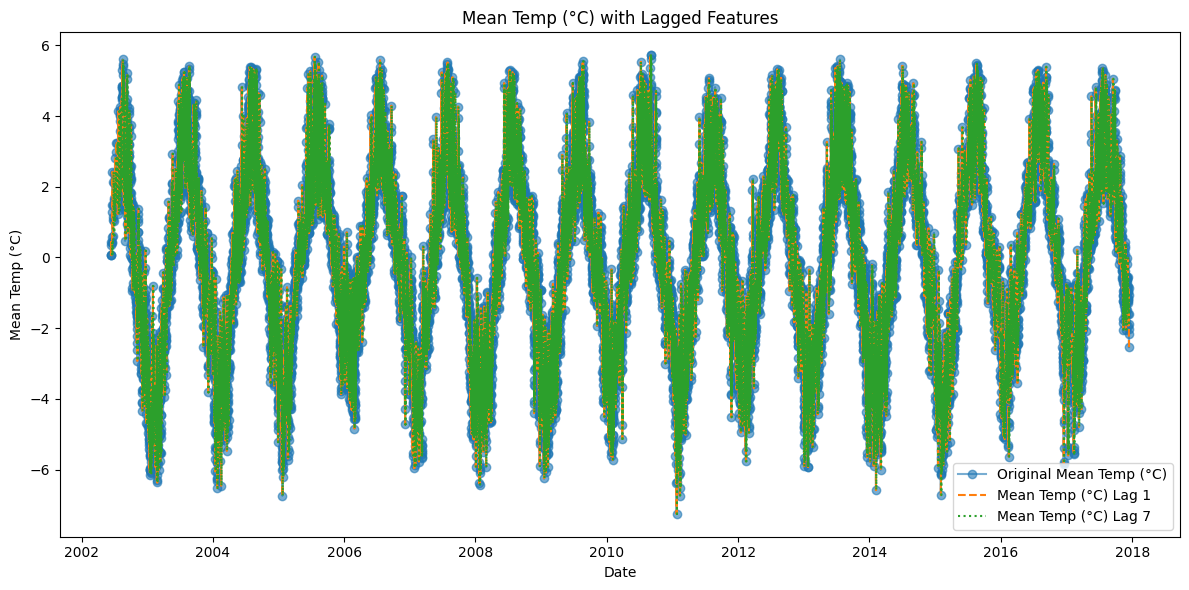

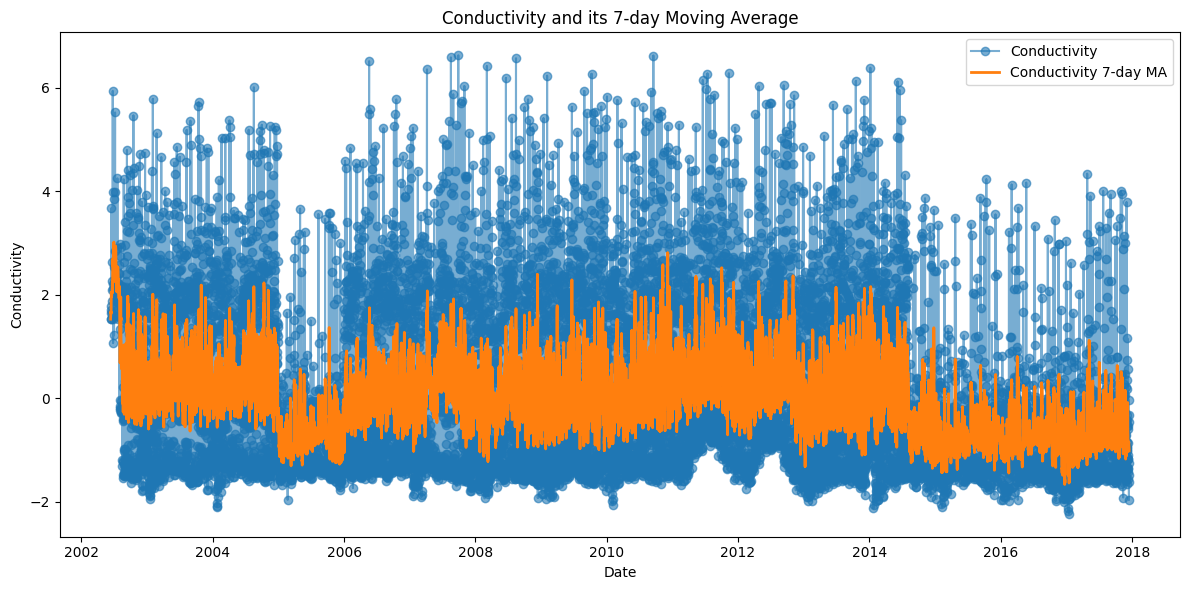

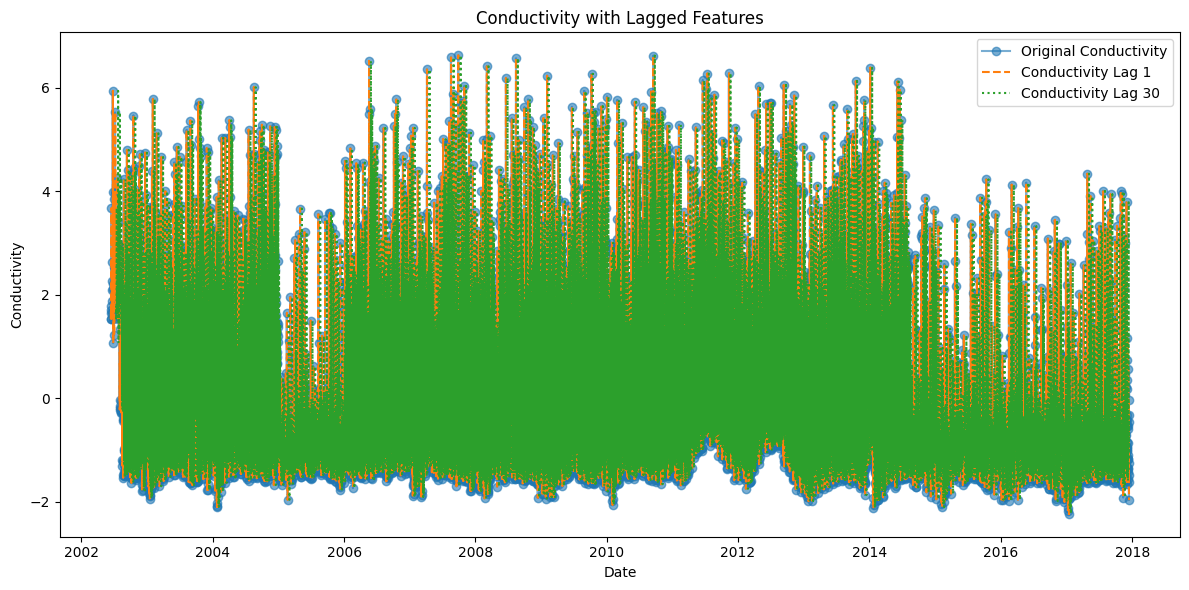


Engineered dataset saved to: /content/drive/MyDrive/Data_Mining/engineered_features.csv


In [ ]:
# 2. Mount Google Drive and Load the Dataset

from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 3. Load the Processed Top-Features Dataset

data_path = '/content/drive/MyDrive/Data_Mining/processed_data_pca.csv'
df = pd.read_csv(data_path)
print("Loaded dataset shape:", df.shape)


# 4. Prepare the Time Series Index

# Convert the "Date" column to datetime and set it as the index.
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    df.set_index('Date', inplace=True)
    print("Dataset indexed by Date.")
else:
    print("No 'Date' column found. Please check your dataset.")


# 5. Define Features for Rolling and Lagged Calculations
features_for_engineering = [
    "Mean Temp (°C)",	"Conductivity",
    "Total Precip (mm)",	"Turbidity",	"Total Snow (cm)",	"Cool Deg Days (°C)",	"Spd of Max Gust (km/h)"
]

features_to_use = [feat for feat in features_for_engineering if feat in df.columns]
print("\nFeatures used for rolling/lagged engineering:", features_to_use)


# 6. Create Rolling Averages

# For each selected feature, create a 7-day rolling average.

for feat in features_to_use:
    # 7-day rolling average
    df[f"{feat}_roll7"] = df[feat].rolling(window=7, min_periods=1).mean()
    # 30-day rolling average for Conductivity
    if feat.lower() == "Conductivity":
        df[f"{feat}_roll30"] = df[feat].rolling(window=30, min_periods=1).mean()


# 7. Create Lagged Features
lags = [1, 3, 7, 14, 30]

for feat in features_to_use:
    for lag in lags:
        df[f"{feat}_lag{lag}"] = df[feat].shift(lag)


# 8. Display Summary Statistics of New Features
print("\nNew feature columns:")
print(df.columns)
print("\nSample of engineered features:")
display(df.head(15))


example_feat = features_to_use[0]
plt.figure(figsize=(12,6))
plt.plot(df.index, df[example_feat], label=example_feat, marker='o', alpha=0.6)
plt.plot(df.index, df[f"{example_feat}_roll7"], label=f"{example_feat} 7-day MA", linewidth=2)
plt.title(f"{example_feat} and its 7-day Moving Average")
plt.xlabel("Date")
plt.ylabel(example_feat)
plt.legend()
plt.tight_layout()
plt.show()

# Plot original and lagged versions for a selected feature
example_feature = "Mean Temp (°C)"
plt.figure(figsize=(12,6))
plt.plot(df.index, df[example_feature], label=f"Original {example_feature}", marker='o', alpha=0.6)
plt.plot(df.index, df[f"{example_feature}_lag1"], label=f"{example_feature} Lag 1", linestyle='--')
plt.plot(df.index, df[f"{example_feature}_lag7"], label=f"{example_feature} Lag 7", linestyle=':')
plt.title(f"{example_feature} with Lagged Features")
plt.xlabel("Date")
plt.ylabel(example_feature)
plt.legend()
plt.tight_layout()
plt.show()

example_feat = "Conductivity"
plt.figure(figsize=(12,6))
plt.plot(df.index, df[example_feat], label=example_feat, marker='o', alpha=0.6)
plt.plot(df.index, df[f"{example_feat}_roll7"], label=f"{example_feat} 7-day MA", linewidth=2)
plt.title(f"{example_feat} and its 7-day Moving Average")
plt.xlabel("Date")
plt.ylabel(example_feat)
plt.legend()
plt.tight_layout()
plt.show()

# Plot original and lagged versions for a selected feature
example_feature = "Conductivity"
plt.figure(figsize=(12,6))
plt.plot(df.index, df[example_feature], label=f"Original {example_feature}", marker='o', alpha=0.6)
plt.plot(df.index, df[f"{example_feature}_lag1"], label=f"{example_feature} Lag 1", linestyle='--')
plt.plot(df.index, df[f"{example_feature}_lag30"], label=f"{example_feature} Lag 30", linestyle=':')
plt.title(f"{example_feature} with Lagged Features")
plt.xlabel("Date")
plt.ylabel(example_feature)
plt.legend()
plt.tight_layout()
plt.show()


# 9. Save the Engineered Dataset to Google Drive

output_path = '/content/drive/MyDrive/Data_Mining/engineered_features.csv'
df_reset = df.reset_index()
df_reset.to_csv(output_path, index=False)
print("\nEngineered dataset saved to:", output_path)


# Clustering Techniques - Outlier Detection Using DBSCAN + Grouping Regions Based on Long-Term Averages + Grouping Similar Years Using Time-Based Clustering

In [ ]:
# 1. Install Required Packages

!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl statsmodels fancyimpute --quiet


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.5 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded dataset shape: (18160, 51)
Columns in dataset: ['Date', 'Location', 'Mean Temp (°C)', 'Conductivity', 'Total Precip (mm)', 'Turbidity', 'Total Snow (cm)', 'Cool Deg Days (°C)', 'Spd of Max Gust (km/h)', 'Mean Temp (°C)_roll7', 'Conductivity_roll7', 'Total Precip (mm)_roll7', 'Turbidity_roll7', 'Total Snow (cm)_roll7', 'Cool Deg Days (°C)_roll7', 'Spd of Max Gust (km/h)_roll7', 'Mean Temp (°C)_lag1', 'Mean Temp (°C)_lag3', 'Mean Temp (°C)_lag7', 'Mean Temp (°C)_lag14', 'Mean Temp (°C)_lag30', 'Conductivity_lag1', 'Conductivity_lag3', 'Conductivity_lag7', 'Conductivity_lag14', 'Conductivity_lag30', 'Total Precip (mm)_lag1', 'Total Precip (mm)_lag3', 'Total Precip (mm)_lag7', 'Total Precip (mm)_lag14', 'Total Precip (mm)_lag30', 'Turbidity_lag1', 'Turbidity_lag3', 'Turbidity_lag7', 'Turbidity_lag14', 'Turbidity_lag30', 'Total Snow (cm)_lag1', 'Total Snow 

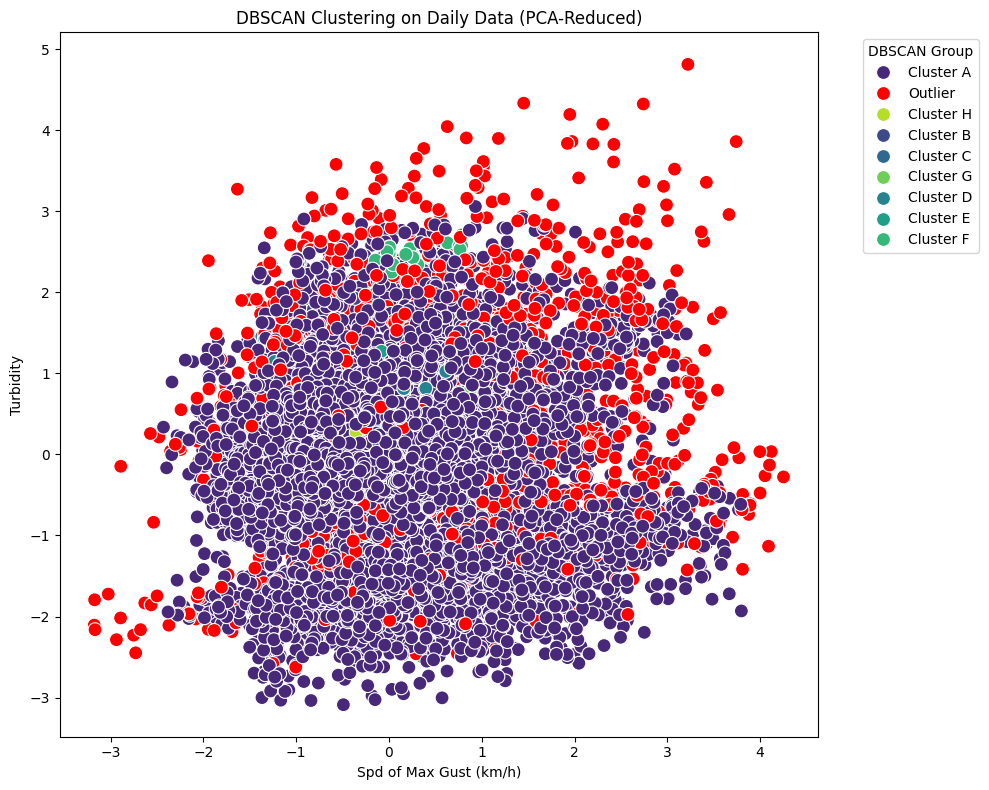


--- Section 2: Grouping Regions (K-Means & Parallel Coordinates) ---
Aggregated regional data shape: (5, 8)


Location  Mean Temp (°C)  Conductivity  Total Precip (mm)  Turbidity  \
0     Kelley       -0.203329     -0.792341           0.071515   0.059528   
1     Lahave        0.432903     -0.016149           0.334284  -0.065464   
2   Margaree       -0.468473      2.114498          -1.125399  -0.281848   
3   Pockwock        0.186827      0.028204           0.506254  -0.082784   
4  Shelburne        0.319118     -1.100217           0.418285   0.267559   

   Total Snow (cm)  Cool Deg Days (°C)  Spd of Max Gust (km/h)  
0         0.593327           -0.311341               -0.324270  
1        -0.284200            0.061817               -0.034950  
2         0.195036           -0.034248               -0.121615  
3        -0.532710            0.173728                0.401187  
4        -0.223894            0.164155                0.107640

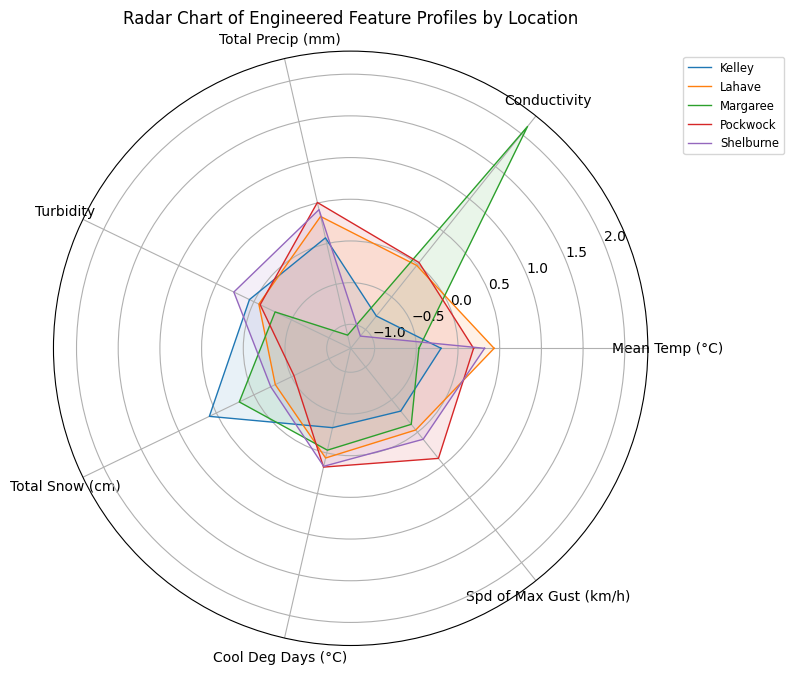

Aggregated regional clusters saved to: /content/drive/MyDrive/Data_Mining/aggregated_clustered_regions.csv

--- Section 3: Grouping Similar Years (Time-Based Clustering) ---
Aggregated yearly data shape: (16, 8)


Year  Mean Temp (°C)  Conductivity  Total Precip (mm)  Turbidity  \
0  2002        0.527482      0.597760          -0.214746  -0.064225   
1  2003       -0.247807      0.389378          -0.197944   0.159119   
2  2004       -0.351170      0.353005          -0.223920   0.164281   
3  2005        0.092972     -0.690728           0.431618  -0.023926   
4  2006        0.172467      0.088045           0.043233  -0.357098   

   Total Snow (cm)  Cool Deg Days (°C)  Spd of Max Gust (km/h)  
0        -0.140144           -0.030716                0.087434  
1        -0.157244            0.240999                0.219507  
2        -0.196596            0.125172                0.165401  
3         0.656642           -0.000232                0.330084  
4         0.773129           -0.138345                0.190784

Yearly PCA Axes labels: X = Total Precip (mm), Y = Turbidity


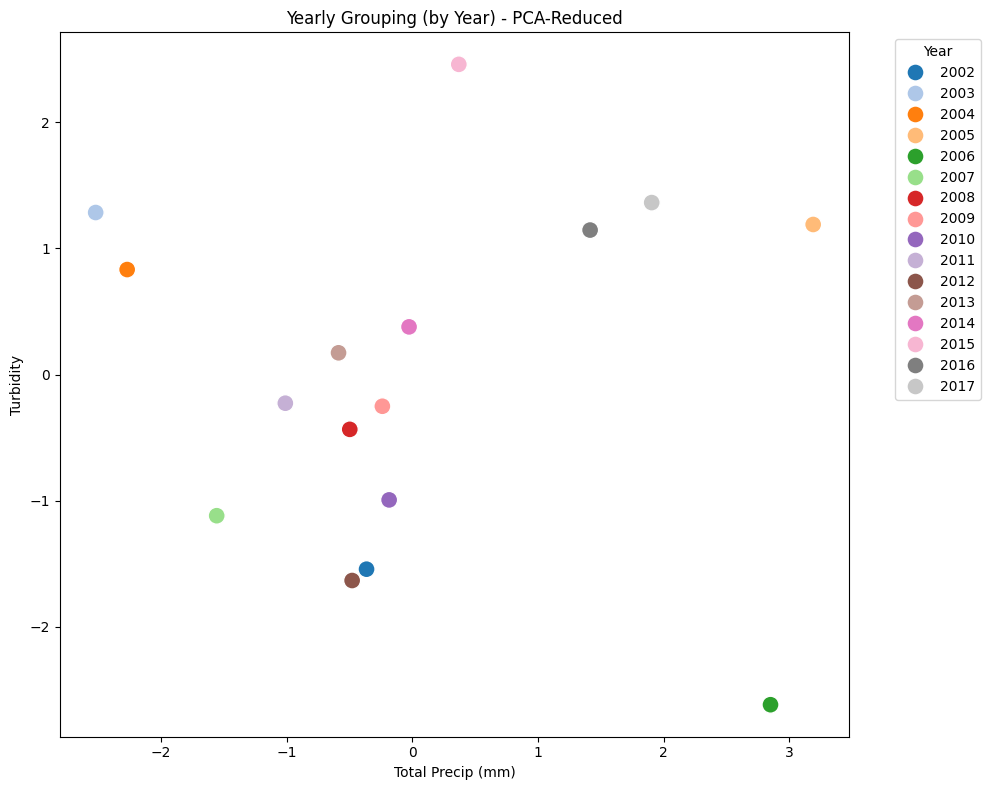

Aggregated yearly data saved to: /content/drive/MyDrive/Data_Mining/aggregated_clustered_year.csv


In [ ]:
# 2. Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import statsmodels.api as sm
from fancyimpute import IterativeSVD

# Load the engineered features dataset.
data_path = '/content/drive/MyDrive/Data_Mining/engineered_features.csv'
df = pd.read_csv(data_path)
print("Loaded dataset shape:", df.shape)
print("Columns in dataset:", df.columns.tolist())


# 3. Format Date Column

if 'Date' not in df.columns:
    raise ValueError("Dataset must contain a 'Date' column.")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)


# 4. Define Engineered Features for Clustering
features_for_engineering = [
    "Mean Temp (°C)", "Conductivity", "Total Precip (mm)", "Turbidity",
    "Total Snow (cm)", "Cool Deg Days (°C)", "Spd of Max Gust (km/h)"
]
selected_features = [feat for feat in features_for_engineering if feat in df.columns]
print("\nSelected engineered features:", selected_features)


# SECTION 1: Outlier Detection using DBSCAN on Daily Data
print("\n--- Section 1: Outlier Detection (DBSCAN) ---")
X_daily = df[selected_features].values

# Standardize daily data.
scaler_daily = StandardScaler()
X_daily_scaled = scaler_daily.fit_transform(X_daily)
print("Daily data scaled. Shape:", X_daily_scaled.shape)

# Apply DBSCAN with adjusted parameters for fewer clusters.
dbscan = DBSCAN(eps=0.8, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_daily_scaled)

# Map DBSCAN labels to descriptive names:
unique_labels = sorted(set(dbscan_labels))
palette = {}
# Always map outliers (-1) to red.
palette["Outlier"] = "red"
# For other clusters, assign colors from a gradient.
others = [label for label in unique_labels if label != -1]
colors = sns.color_palette("viridis", len(others))
for label, col in zip(others, colors):
    # Convert numeric label to letter
    palette[f"Cluster {chr(65 + label)}"] = col

def map_label(l):
    return "Outlier" if l == -1 else f"Cluster {chr(65 + l)}"

dbscan_mapped = [map_label(l) for l in dbscan_labels]
df['DBSCAN_Label'] = dbscan_labels
df['DBSCAN_Group'] = dbscan_mapped

# Use PCA for visualization.
pca_daily = PCA(n_components=2)
X_daily_pca = pca_daily.fit_transform(X_daily_scaled)
# Determine dominant features for axis labels.
loadings_daily = pca_daily.components_
pc1_dom = selected_features[np.argmax(np.abs(loadings_daily[0]))]
pc2_dom = selected_features[np.argmax(np.abs(loadings_daily[1]))]
print(f"DBSCAN PCA Axes labels: X = {pc1_dom}, Y = {pc2_dom}")

plt.figure(figsize=(10,8))
sns.scatterplot(x=X_daily_pca[:,0], y=X_daily_pca[:,1], hue=dbscan_mapped,
                palette=palette, s=100)
plt.title("DBSCAN Clustering on Daily Data (PCA-Reduced)")
plt.xlabel(pc1_dom)
plt.ylabel(pc2_dom)
plt.legend(title="DBSCAN Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# SECTION 2: Grouping Regions Using K-Means & Parallel Coordinates

print("\n--- Section 2: Grouping Regions (K-Means & Parallel Coordinates) ---")
if 'Location' not in df.columns:
    raise ValueError("Dataset must contain 'Location' for regional grouping.")

# Aggregate by Location: compute mean for each selected feature.
agg_regions = df.groupby("Location").agg({feat: 'mean' for feat in selected_features}).reset_index()
print("Aggregated regional data shape:", agg_regions.shape)
display(agg_regions.head())

# Standardize aggregated features.
scaler_regions = StandardScaler()
X_regions = scaler_regions.fit_transform(agg_regions[selected_features])

# Apply K-Means clustering with 5 clusters.
n_clusters_regions = 5
kmeans_regions = KMeans(n_clusters=n_clusters_regions, random_state=42)
region_labels = kmeans_regions.fit_predict(X_regions)
agg_regions['Region_Cluster'] = region_labels
# Map cluster numbers to descriptive names
region_mapping = {i: f"Cluster {chr(65 + i)}" for i in range(n_clusters_regions)}
agg_regions['Region_Group'] = agg_regions['Region_Cluster'].map(region_mapping)

import matplotlib.pyplot as plt
import numpy as np

subset = agg_regions.set_index("Location")[selected_features].iloc[:10]

num_features = len(selected_features)
angles = np.linspace(0, 2*np.pi, num_features, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

for loc in subset.index:
    data = subset.loc[loc].values.tolist()
    data += data[:1]
    ax.plot(angles, data, linewidth=1, label=loc)
    ax.fill(angles, data, alpha=0.1)

ax.set_thetagrids(np.degrees(angles[:-1]), selected_features)
plt.title("Radar Chart of Engineered Feature Profiles by Location", pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


output_path_regions = '/content/drive/MyDrive/Data_Mining/aggregated_clustered_regions.csv'
agg_regions.to_csv(output_path_regions, index=False)
print("Aggregated regional clusters saved to:", output_path_regions)


# SECTION 3: Grouping Similar Years using K-Means (Time-Based Clustering)

print("\n--- Section 3: Grouping Similar Years (Time-Based Clustering) ---")

df['Year'] = df['Date'].dt.year

# Aggregate by Year (across all locations) using mean of selected features.
agg_year = df.groupby("Year").agg({feat: 'mean' for feat in selected_features}).reset_index()
print("Aggregated yearly data shape:", agg_year.shape)
display(agg_year.head())

# Standardize the yearly aggregated data.
scaler_year = StandardScaler()
X_year = scaler_year.fit_transform(agg_year[selected_features])

# Apply K-Means clustering on yearly data
year_labels = agg_year['Year'].astype(str)

# Use PCA for visualization.
pca_year = PCA(n_components=2)
X_year_pca = pca_year.fit_transform(X_year)
loadings_year = pca_year.components_
pc1_year = selected_features[np.argmax(np.abs(loadings_year[0]))]
pc2_year = selected_features[np.argmax(np.abs(loadings_year[1]))]
print(f"Yearly PCA Axes labels: X = {pc1_year}, Y = {pc2_year}")

plt.figure(figsize=(10,8))
sns.scatterplot(x=X_year_pca[:,0], y=X_year_pca[:,1], hue=year_labels,
                palette="tab20", s=150)
plt.title("Yearly Grouping (by Year) - PCA-Reduced")
plt.xlabel(pc1_year)
plt.ylabel(pc2_year)
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

output_path_year = '/content/drive/MyDrive/Data_Mining/aggregated_clustered_year.csv'
agg_year.to_csv(output_path_year, index=False)
print("Aggregated yearly data saved to:", output_path_year)


# GBM for Structured Data

In [ ]:
# 1. Install Required Packages

!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl statsmodels xgboost lightgbm --quiet

In [ ]:
# 2. Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Load the engineered features dataset.
data_path = '/content/drive/MyDrive/Data_Mining/engineered_features.csv'
df = pd.read_csv(data_path)
print("Loaded dataset shape:", df.shape)
print("Columns:", df.columns.tolist())


# 3. Format Date Column
if 'Date' not in df.columns:
    raise ValueError("Dataset must contain a 'Date' column.")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)


# 4. Define Features for Engineering and Model Building

features_for_engineering = [
    "Mean Temp (°C)", "Conductivity", "Total Precip (mm)", "Turbidity",
    "Total Snow (cm)", "Cool Deg Days (°C)", "Spd of Max Gust (km/h)"
]
# For label generation we exclude "Turbidity" (due to high missingness)
model_features = [feat for feat in features_for_engineering if feat != "Turbidity" and feat in df.columns]
print("\nModel features used for output label generation:", model_features)


# 5. Output Label Generation – Approach 1: Anomaly Detection (Unsupervised)

# Use Isolation Forest on the combined engineered features (excluding Turbidity).
X_anom = df[model_features].fillna(df[model_features].median())
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anom_pred = iso_forest.fit_predict(X_anom)
# In IsolationForest, outliers are -1. Create binary label: 1 for anomaly (potential outbreak), 0 otherwise.
df["Label_Anomaly"] = (anom_pred == -1).astype(int)
print("\nAnomaly detection label distribution:")
print(df["Label_Anomaly"].value_counts())


# 6. Output Label Generation – Approach 2: Proxy Labels (Weak Supervision)

# Define proxy features
proxy_features = model_features.copy()
# Compute 75th percentiles for each proxy feature.
thresholds = {}
for feat in proxy_features:
    thresholds[feat] = df[feat].quantile(0.75)

# Define rule: if at least 3 out of the proxy features exceed their 75th percentile, label outbreak as 1.
def proxy_rule(row):
    count = sum([1 if row[feat] > thresholds[feat] else 0 for feat in proxy_features])
    return 1 if count >= 3 else 0

df["Label_Proxy"] = df.apply(proxy_rule, axis=1)
print("\nProxy label distribution:")
print(df["Label_Proxy"].value_counts())


# 7. Prepare Data for GBM Modeling

X_model = df[model_features].fillna(df[model_features].median())
non_numeric = df[["Location", "Date"]].copy()

y_anom = df["Label_Anomaly"]
y_proxy = df["Label_Proxy"]


# 8. Define a Function to Train & Evaluate a Classifier
def evaluate_model(clf, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    return acc, auc, f1


# 9. Evaluate GBM Variants for Each Output Label Type

!pip install xgboost lightgbm --quiet
results = []

# Define model variants.
models = {
    "GB Classifier": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=42)
}

# Evaluate for Anomaly-based labels.
for name, clf in models.items():
    acc, auc, f1 = evaluate_model(clf, X_model, y_anom)
    results.append({"Model": name, "Label_Type": "Anomaly", "Accuracy": acc, "ROC_AUC": auc, "F1_Score": f1})

# Evaluate for Proxy-based labels.
for name, clf in models.items():
    acc, auc, f1 = evaluate_model(clf, X_model, y_proxy)
    results.append({"Model": name, "Label_Type": "Proxy", "Accuracy": acc, "ROC_AUC": auc, "F1_Score": f1})

results_df = pd.DataFrame(results)
print("\nComparison of GBM Variants for Output Label Prediction:")
print(results_df)

# Save the results table to Google Drive.
output_path_results = '/content/drive/MyDrive/Data_Mining/gbm_comparison_results.csv'
results_df.to_csv(output_path_results, index=False)
print("GBM comparison results saved to:", output_path_results)


# 10. Perform GBM Analysis with the Best Model

# Here we train the best model variant on the full dataset
best_gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
best_gbm.fit(X_model, y_anom)
df["Predicted_Risk_Score"] = best_gbm.predict_proba(X_model)[:, 1]

# Define risk level based on predicted risk score.
def risk_level(score):
    if score >= 0.7:
        return "High"
    elif score >= 0.4:
        return "Moderate"
    else:
        return "Low"

df["Risk_Level"] = df["Predicted_Risk_Score"].apply(risk_level)


# 11. Save the Final GBM Results to Google Drive
final_columns = ["Location", "Date"] + features_for_engineering + ["Label_Anomaly", "Label_Proxy", "Predicted_Risk_Score", "Risk_Level"]
output_path_gbm = '/content/drive/MyDrive/Data_Mining/gbm_results.csv'
df[final_columns].to_csv(output_path_gbm, index=False)
print("\nGBM results (with risk scores and risk levels) saved to:", output_path_gbm)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded dataset shape: (18160, 45)
Columns: ['Date', 'Location', 'Mean Temp (°C)', 'Conductivity', 'Total Precip (mm)', 'Turbidity', 'Total Snow (cm)', 'Cool Deg Days (°C)', 'Spd of Max Gust (km/h)', 'Mean Temp (°C)_roll7', 'Conductivity_roll7', 'Total Precip (mm)_roll7', 'Turbidity_roll7', 'Turbidity_roll30', 'Total Snow (cm)_roll7', 'Cool Deg Days (°C)_roll7', 'Spd of Max Gust (km/h)_roll7', 'Mean Temp (°C)_lag1', 'Mean Temp (°C)_lag3', 'Mean Temp (°C)_lag7', 'Mean Temp (°C)_lag14', 'Conductivity_lag1', 'Conductivity_lag3', 'Conductivity_lag7', 'Conductivity_lag14', 'Total Precip (mm)_lag1', 'Total Precip (mm)_lag3', 'Total Precip (mm)_lag7', 'Total Precip (mm)_lag14', 'Turbidity_lag1', 'Turbidity_lag3', 'Turbidity_lag7', 'Turbidity_lag14', 'Total Snow (cm)_lag1', 'Total Snow (cm)_lag3', 'Total Snow (cm)_lag7', 'Total Snow (cm)_lag14', 'Cool Deg Days (°C)_la

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:21:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 636, number of negative: 12076
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 12712, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050031 -> initscore=-2.943777
[LightGBM] [Info] Start training from score -2.943777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:21:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2460, number of negative: 10252
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 12712, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193518 -> initscore=-1.427311
[LightGBM] [Info] Start training from score -1.427311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

# GRU-Based Time-Series Modeling for Contamination Prediction

In [ ]:
# 1. Install Required Packages

!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl statsmodels xgboost lightgbm tensorflow --quiet


In [ ]:
# 2. Import Libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

# 2. Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')


# 3. Define Helper Functions

def create_sequences(df, features, target, sequence_length=30):
    X_list, y_list = [], []
    # Group by Location
    for loc, group in df.groupby("Location"):
        group = group.sort_values("Date")
        group.reset_index(drop=True, inplace=True)
        data = group[features].values
        labels = group[target].values
        # Create sliding windows: use window and next day as label
        for i in range(len(group) - sequence_length):
            X_list.append(data[i:i+sequence_length])
            y_list.append(labels[i+sequence_length])
    return np.array(X_list), np.array(y_list)

def build_gru_model(input_shape, variant=1):
    model = Sequential()
    if variant == 1:
        model.add(GRU(32, input_shape=input_shape, return_sequences=False))
        model.add(Dropout(0.2))
    elif variant == 2:
        model.add(GRU(64, input_shape=input_shape, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(GRU(32, return_sequences=False))
        model.add(Dropout(0.2))
    elif variant == 3:
        model.add(GRU(128, input_shape=input_shape, return_sequences=True))
        model.add(Dropout(0.5))
        model.add(GRU(64, return_sequences=False))
        model.add(Dropout(0.3))
    else:
        raise ValueError("Unknown variant")
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def evaluate_gru_model(model, X_train, y_train, X_test, y_test, epochs=20, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    y_pred_prob = model.predict(X_test).flatten()
    y_pred = (y_pred_prob >= 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    try:
        auc = roc_auc_score(y_test, y_pred_prob)
    except:
        auc = 0.0
    f1 = f1_score(y_test, y_pred)
    return acc, auc, f1

def create_comparison_table(results):
    return pd.DataFrame(results)

# 4. Define Features for Engineering and Model Building

# Engineered features list
features_for_engineering = [
    "Mean Temp (°C)", "Conductivity", "Total Precip (mm)", "Turbidity",
    "Total Snow (cm)", "Cool Deg Days (°C)", "Spd of Max Gust (km/h)"
]


# 4. Experiment 1: GRU on GBM Results Dataset

# Load GBM results dataset
gbm_data_path = '/content/drive/MyDrive/Data_Mining/gbm_results.csv'
df_gbm = pd.read_csv(gbm_data_path)
print("\n[Experiment 1] GBM Results dataset shape:", df_gbm.shape)
print("Columns:", df_gbm.columns.tolist())

df_gbm['Date'] = pd.to_datetime(df_gbm['Date'])
df_gbm = df_gbm.sort_values('Date').reset_index(drop=True)

# For Experiment 1, we use the following features:
features_exp1 = [
    "Mean Temp (°C)", "Conductivity", "Total Precip (mm)",
    "Turbidity", "Total Snow (cm)", "Cool Deg Days (°C)", "Spd of Max Gust (km/h)"
]

target_exp1 = "Label_Anomaly"

# Ensure no missing values in features (impute with median if needed)
df_gbm[features_exp1] = df_gbm[features_exp1].fillna(df_gbm[features_exp1].median())

# Create sequences (using a 30-day window)
X_exp1, y_exp1 = create_sequences(df_gbm, features_exp1, target_exp1, sequence_length=30)
print(f"[Experiment 1] Sequences created: X shape = {X_exp1.shape}, y shape = {y_exp1.shape}")

# Split into train and test sets.
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_exp1, y_exp1, test_size=0.3, random_state=42, stratify=y_exp1)

# Define input shape for GRU: (sequence_length, num_features)
input_shape = X_train1.shape[1:]

# Train three GRU variants for Experiment 1.
exp1_results = []
for variant in [1, 2, 3]:
    model = build_gru_model(input_shape, variant=variant)
    acc, auc, f1 = evaluate_gru_model(model, X_train1, y_train1, X_test1, y_test1, epochs=20, batch_size=32)
    exp1_results.append({
        "GRU_Variant": f"Variant {variant}",
        "Experiment": "GBM Results",
        "Accuracy": acc,
        "ROC_AUC": auc,
        "F1_Score": f1
    })
    print(f"[Exp1] GRU Variant {variant}: Accuracy={acc:.3f}, ROC_AUC={auc:.3f}, F1_Score={f1:.3f}")


# 5. Experiment 2: GRU on Engineered Features with Rolling & Lagged Features

# Load engineered features with rolling and lagged features dataset.
eng_data_path = '/content/drive/MyDrive/Data_Mining/engineered_features.csv'
df_eng = pd.read_csv(eng_data_path)
print("\n[Experiment 2] Engineered Features dataset shape:", df_eng.shape)
print("Columns:", df_eng.columns.tolist())

if 'Date' not in df_eng.columns or 'Location' not in df_eng.columns:
    raise ValueError("Dataset must contain 'Date' and 'Location' columns.")
df_eng['Date'] = pd.to_datetime(df_eng['Date'])
df_eng = df_eng.sort_values('Date').reset_index(drop=True)

# For Experiment 2, use all engineered features including rolling and lagged features.

features_exp2 = df_eng.columns[2:].tolist()  # all engineered features from column 3 onward

# --- Generate Output Labels for Experiment 2 ---
# Approach: Proxy Labels (Weak Supervision)
# Compute 75th percentiles for a subset
proxy_features = [feat for feat in features_exp2 if feat.split('_')[0] in features_for_engineering]
thresholds = {feat: df_eng[feat].quantile(0.75) for feat in proxy_features}
def proxy_rule(row):
    count = sum([1 if row[feat] > thresholds[feat] else 0 for feat in proxy_features])
    return 1 if count >= 3 else 0
df_eng["Label_Proxy"] = df_eng.apply(proxy_rule, axis=1)
print("\n[Experiment 2] Proxy label distribution:")
print(df_eng["Label_Proxy"].value_counts())
target_exp2 = "Label_Proxy"

# Impute missing values in engineered features.
df_eng[features_exp2] = df_eng[features_exp2].fillna(df_eng[features_exp2].median())

# Create sequences (30-day windows) using engineered features.
X_exp2, y_exp2 = create_sequences(df_eng, features_exp2, target_exp2, sequence_length=30)
print(f"[Experiment 2] Sequences created: X shape = {X_exp2.shape}, y shape = {y_exp2.shape}")

# Split into train and test sets.
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_exp2, y_exp2, test_size=0.3, random_state=42, stratify=y_exp2)
input_shape2 = X_train2.shape[1:]

# Train three GRU variants for Experiment 2.
exp2_results = []
for variant in [1, 2, 3]:
    model = build_gru_model(input_shape2, variant=variant)
    acc, auc, f1 = evaluate_gru_model(model, X_train2, y_train2, X_test2, y_test2, epochs=20, batch_size=32)
    exp2_results.append({
        "GRU_Variant": f"Variant {variant}",
        "Experiment": "Engineered Features",
        "Accuracy": acc,
        "ROC_AUC": auc,
        "F1_Score": f1
    })
    print(f"[Exp2] GRU Variant {variant}: Accuracy={acc:.3f}, ROC_AUC={auc:.3f}, F1_Score={f1:.3f}")


# 6. Comparison Tables

exp1_df = pd.DataFrame(exp1_results)
exp2_df = pd.DataFrame(exp2_results)
combined_df = pd.concat([exp1_df, exp2_df], ignore_index=True)

print("\n--- Experiment 1: GRU on GBM Results ---")
print(exp1_df)
print("\n--- Experiment 2: GRU on Engineered Features ---")
print(exp2_df)
print("\n--- Combined GRU Experiment Comparison ---")
print(combined_df)

# Save comparison tables to CSV.
output_path_exp1 = '/content/drive/MyDrive/Data_Mining/gru_exp1_comparison.csv'
output_path_exp2 = '/content/drive/MyDrive/Data_Mining/gru_exp2_comparison.csv'
output_path_combined = '/content/drive/MyDrive/Data_Mining/gru_combined_comparison.csv'
exp1_df.to_csv(output_path_exp1, index=False)
exp2_df.to_csv(output_path_exp2, index=False)
combined_df.to_csv(output_path_combined, index=False)
print("\nComparison tables saved to:")
print(output_path_exp1)
print(output_path_exp2)
print(output_path_combined)


Mounted at /content/drive

[Experiment 1] GBM Results dataset shape: (18160, 13)
Columns: ['Location', 'Date', 'Mean Temp (°C)', 'Conductivity', 'Total Precip (mm)', 'Turbidity', 'Total Snow (cm)', 'Cool Deg Days (°C)', 'Spd of Max Gust (km/h)', 'Label_Anomaly', 'Label_Proxy', 'Predicted_Risk_Score', 'Risk_Level']
[Experiment 1] Sequences created: X shape = (18010, 30, 7), y shape = (18010,)
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[Exp1] GRU Variant 1: Accuracy=0.953, ROC_AUC=0.797, F1_Score=0.221
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Exp1] GRU Variant 2: Accuracy=0.952, ROC_AUC=0.795, F1_Score=0.245
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Exp1] GRU Variant 3: Accuracy=0.954, ROC_AUC=0.793, F1_Score=0.313

[Experiment 2] Engineered Features dataset shape: (18160, 51)
Columns: ['Date', 'Location', 'Mean Temp (°C)', 'Conductivity', 'Total Precip (mm)', 'Turbidity', 'Total Snow (cm)', 'Cool Deg Days (°C)', 'Spd of Max Gust (km/h)', 'Mean Temp (°C)_roll7', 'Conductivity_roll7', 'Tot

# Statistical Evaluation of GRU Architectures Using Paired t-Test Analysis

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[Run 1 | Variant 1] Accuracy=0.967, ROC_AUC=0.889, F1_Score=0.983
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[Run 2 | Variant 1] Accuracy=0.967, ROC_AUC=0.899, F1_Score=0.983
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[Run 3 | Variant 1] Accuracy=0.968, ROC_AUC=0.901, F1_Score=0.983
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[Run 4 | Variant 1] Accuracy=0.966, ROC_AUC=0.897, F1_Score=0.983
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[Run 5 | Variant 1] Accuracy=0.967, ROC_AUC=0.870, F1_Score=0.983
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Run 1 | Variant 2] Accuracy=0.966, ROC_AUC=0.861, F1_Score=0.982
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Run 2 | Variant 2] Accuracy=0.963, ROC_AUC=0.868, F1_Score=0.981
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Run 3 | Variant 2] Accuracy=0.965, ROC_AUC=0.889, F1_Score=0.982
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Run 4 | Variant 2] Accuracy=0.963, ROC_AUC=0.889, F1_Score=0.981
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/s

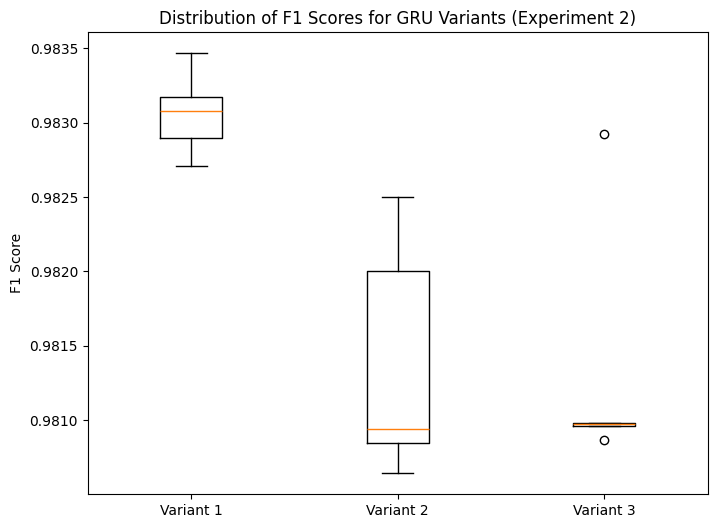

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# Number of repeated runs for each variant
num_repeats = 5

# Dictionary to store results for each variant from Experiment 2
results_exp2_repeat = {1: [], 2: [], 3: []}

# Run repeated experiments for each GRU variant on Experiment 2 data
for variant in [1, 2, 3]:
    for run in range(num_repeats):
        model = build_gru_model(input_shape2, variant=variant)
        acc, auc, f1 = evaluate_gru_model(model, X_train2, y_train2, X_test2, y_test2, epochs=20, batch_size=32)
        results_exp2_repeat[variant].append({'Accuracy': acc, 'ROC_AUC': auc, 'F1_Score': f1})
        print(f"[Run {run+1} | Variant {variant}] Accuracy={acc:.3f}, ROC_AUC={auc:.3f}, F1_Score={f1:.3f}")

# Extract F1 Scores for statistical comparison
f1_variant1 = np.array([res['F1_Score'] for res in results_exp2_repeat[1]])
f1_variant2 = np.array([res['F1_Score'] for res in results_exp2_repeat[2]])
f1_variant3 = np.array([res['F1_Score'] for res in results_exp2_repeat[3]])

# Perform paired t-tests between variants for F1 Score
t_stat_12, p_val_12 = ttest_rel(f1_variant1, f1_variant2)
t_stat_13, p_val_13 = ttest_rel(f1_variant1, f1_variant3)
t_stat_23, p_val_23 = ttest_rel(f1_variant2, f1_variant3)

print("\nPaired t-test results for F1 Scores (Experiment 2):")
print(f"Variant 1 vs Variant 2: t-statistic = {t_stat_12:.3f}, p-value = {p_val_12:.3f}")
print(f"Variant 1 vs Variant 3: t-statistic = {t_stat_13:.3f}, p-value = {p_val_13:.3f}")
print(f"Variant 2 vs Variant 3: t-statistic = {t_stat_23:.3f}, p-value = {p_val_23:.3f}")

# Visualize the distribution of F1 Scores for each variant using a boxplot
data = [f1_variant1, f1_variant2, f1_variant3]
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=["Variant 1", "Variant 2", "Variant 3"])
plt.title("Distribution of F1 Scores for GRU Variants (Experiment 2)")
plt.ylabel("F1 Score")
plt.show()


# Exploring Simpler Time-Series Models: Kalman Filters

In [ ]:
# 1. Install Required Packages

!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl statsmodels pykalman --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 13.4 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded dataset shape: (18160, 38)
Columns: ['Location', 'Date', 'Temperature', 'pH', 'Conductivity', 'Dissolved Oxygen', 'Turbidity', 'Stage', 'Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Year', 'Month', 'Day', 'Data Quality', 'Max Temp (°C)', 'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag', 'Mean Temp (°C)', 'Mean Temp Flag', 'Heat Deg Days (°C)', 'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag', 'Total Precip (mm)', 'Total Precip Flag', 'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag']

Using location: Margaree
Time series length: 4074


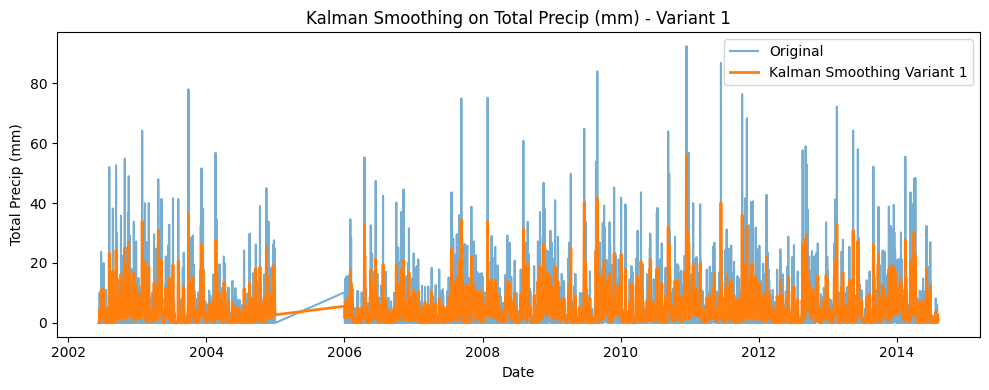

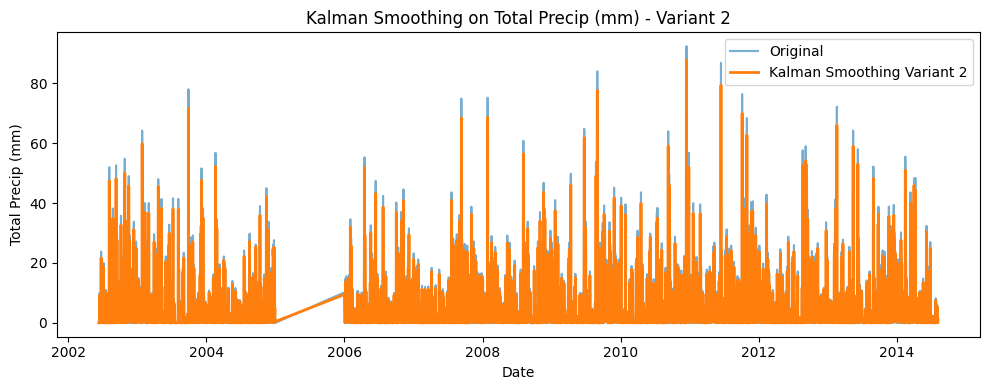

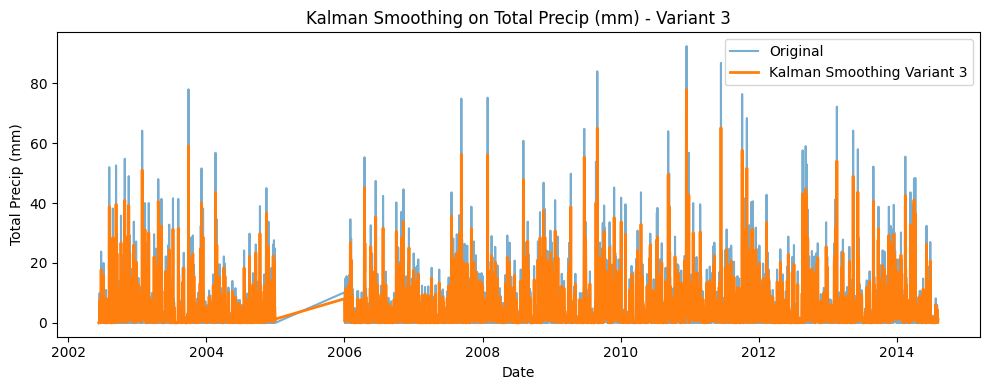

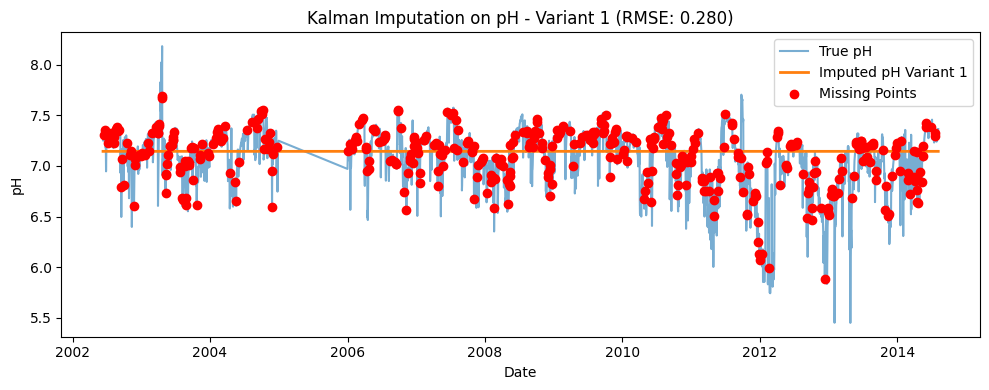

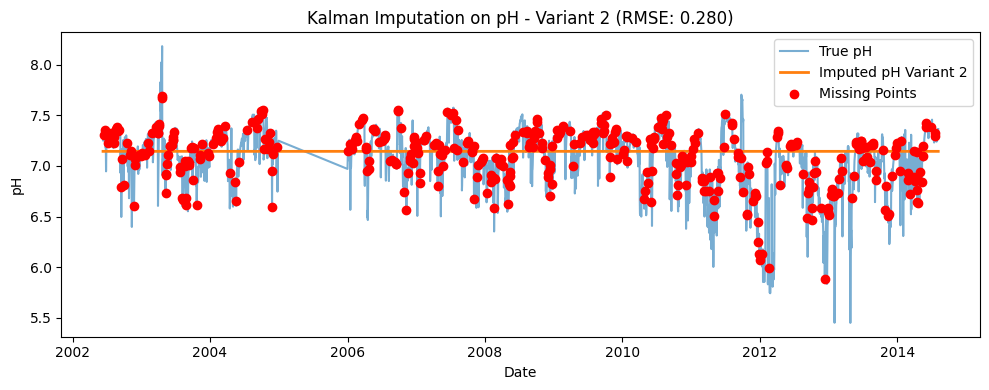

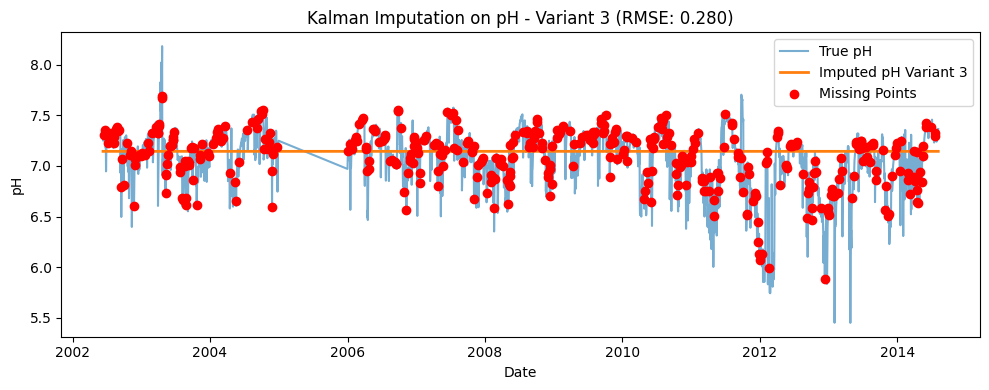

Forecasted Total Precip (mm) using Variant 1: 0.739 (RMSE: 3.061)
Forecasted Total Precip (mm) using Variant 2: 0.000 (RMSE: 3.800)
Forecasted Total Precip (mm) using Variant 3: 0.016 (RMSE: 3.784)

Comparison of Kalman Filter Experiments:
            Experiment    Variant  Metric      RMSE        Forecasted_Value
0            Smoothing  Variant 1  Visual       N/A                     N/A
1            Smoothing  Variant 2  Visual       N/A                     N/A
2            Smoothing  Variant 3  Visual       N/A                     N/A
3   Missing Imputation  Variant 1    RMSE  0.279909                     N/A
4   Missing Imputation  Variant 2    RMSE  0.279909                     N/A
5   Missing Imputation  Variant 3    RMSE  0.279909                     N/A
6  Forecasting (1-day)  Variant 1    RMSE  3.060525    [0.7394753843900523]
7  Forecasting (1-day)  Variant 2    RMSE  3.799992  [8.15916338724361e-06]
8  Forecasting (1-day)  Variant 3    RMSE  3.783762  [0.016237620578915146]


In [ ]:
# 2. Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pykalman import KalmanFilter
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# Load the dataset
data_path = '/content/drive/MyDrive/Data_Mining/merged_imputed_data.csv'
df = pd.read_csv(data_path)
print("Loaded dataset shape:", df.shape)
print("Columns:", df.columns.tolist())


# Format Date column and sort.
if 'Date' not in df.columns or 'Location' not in df.columns:
    raise ValueError("Dataset must contain 'Date' and 'Location' columns.")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

location = df['Location'].unique()[0]
df_loc = df[df['Location'] == location].copy().sort_values('Date').reset_index(drop=True)
print("\nUsing location:", location)
print("Time series length:", len(df_loc))


# Define features for experiments
features_for_engineering = [
    "Mean Temp (°C)", "Conductivity", "Total Precip (mm)", "Turbidity",
    "Total Snow (cm)", "Cool Deg Days (°C)", "Spd of Max Gust (km/h)", "pH", "Dissolved Oxygen"
]

# Ensure the chosen features exist.
for feat in features_for_engineering:
    if feat not in df_loc.columns:
        raise ValueError(f"Feature {feat} not found in the dataset.")


# Experiment 1: Smoothing Experiment on "Total Precip (mm)"

y_smooth = df_loc["Total Precip (mm)"].values

def run_kalman_smoothing(y, variant):
    # Base parameters.
    transition_matrix = 1.0
    observation_matrix = 1.0
    transition_covariance = 1.0
    observation_covariance = 1.0
    if variant == 1:
        pass
    elif variant == 2:
        observation_covariance = 0.05
    elif variant == 3:
        transition_covariance = 5.0
    else:
        raise ValueError("Unknown variant")

    kf = KalmanFilter(
        transition_matrices = transition_matrix,
        observation_matrices = observation_matrix,
        transition_covariance = transition_covariance,
        observation_covariance = observation_covariance,
        initial_state_mean = y[0],
        initial_state_covariance = 1.0
    )
    state_means, _ = kf.smooth(y)
    # Replace any remaining NaNs with median.
    state_means = np.where(np.isnan(state_means), np.nanmedian(y), state_means)
    return state_means

smoothing_results = {}
for variant in [1, 2, 3]:
    smoothed = run_kalman_smoothing(y_smooth, variant)
    smoothing_results[f"Variant {variant}"] = smoothed
    plt.figure(figsize=(10,4))
    plt.plot(df_loc["Date"], y_smooth, label="Original", alpha=0.6)
    plt.plot(df_loc["Date"], smoothed, label=f"Kalman Smoothing Variant {variant}", linewidth=2)
    plt.title(f"Kalman Smoothing on Total Precip (mm) - Variant {variant}")
    plt.xlabel("Date")
    plt.ylabel("Total Precip (mm)")
    plt.legend()
    plt.tight_layout()
    plt.show()

smoothing_comparison = [{"Experiment": "Smoothing", "Variant": f"Variant {v}", "Metric": "Visual", "RMSE": "N/A", "Forecasted_Value": "N/A"}
                        for v in [1,2,3]]


# Experiment 2: Missing Data Imputation on "pH"

y_cond = df_loc["pH"].values.copy()

np.random.seed(42)
mask = np.random.rand(len(y_cond)) < 0.1
y_true = y_cond.copy()
y_cond[mask] = np.nan

def run_kalman_imputation(y, variant):
    transition_matrix = 1.0
    observation_matrix = 1.0

    if variant == 1:
        transition_covariance = 1.0
        observation_covariance = 1.0
    elif variant == 2:
        transition_covariance = 1.0
        observation_covariance = 0.001  # Very low measurement noise
    elif variant == 3:
        transition_covariance = 20.0  # Higher process noise
        observation_covariance = 1.0
    else:
        raise ValueError("Unknown variant")

    kf = KalmanFilter(
        transition_matrices=transition_matrix,
        observation_matrices=observation_matrix,
        transition_covariance=transition_covariance,
        observation_covariance=observation_covariance,
        initial_state_mean = np.nanmean(y),
        initial_state_covariance = 1.0
    )
    state_means, _ = kf.smooth(y)
    # Replace any NaNs with median of y.
    state_means = np.where(np.isnan(state_means), np.nanmedian(y), state_means)
    return state_means

imputation_results = {}
rmse_results = {}
for variant in [1, 2, 3]:
    imputed = run_kalman_imputation(y_cond, variant)
    imputation_results[f"Variant {variant}"] = imputed
    # Compute RMSE only on indices where original data was missing.
    imputed_fixed = np.where(np.isnan(imputed), np.nanmedian(y_true), imputed)
    rmse = np.sqrt(mean_squared_error(y_true[mask], imputed_fixed[mask]))
    rmse_results[f"Variant {variant}"] = rmse
    plt.figure(figsize=(10,4))
    plt.plot(df_loc["Date"], y_true, label="True pH", alpha=0.6)
    plt.plot(df_loc["Date"], imputed_fixed, label=f"Imputed pH Variant {variant}", linewidth=2)
    plt.scatter(df_loc["Date"][mask], y_true[mask], color='red', label="Missing Points", zorder=5)
    plt.title(f"Kalman Imputation on pH - Variant {variant} (RMSE: {rmse:.3f})")
    plt.xlabel("Date")
    plt.ylabel("pH")
    plt.legend()
    plt.tight_layout()
    plt.show()

imputation_comparison = []
for variant in [1,2,3]:
    imputation_comparison.append({
        "Experiment": "Missing Imputation",
        "Variant": f"Variant {variant}",
        "Metric": "RMSE",
        "RMSE": rmse_results[f"Variant {variant}"],
        "Forecasted_Value": "N/A"
    })


# Experiment 3: Forecasting on "Total Precip (mm)"

# For forecasting, split the series: use the first N points as training and the next as test.
y_precip = df_loc["Total Precip (mm)"].values

if len(y_precip) < 31:
    raise ValueError("Not enough data points for forecasting experiment (need at least 31).")
train_precip = y_precip[:-10]
test_precip = y_precip[-10:]

def forecast_kalman(y_train, variant):
    transition_matrix = 1.0
    observation_matrix = 1.0
    if variant == 1:
        transition_covariance = 1.0
        observation_covariance = 1.0
    elif variant == 2:
        transition_covariance = 1.0
        observation_covariance = 0.001
    elif variant == 3:
        transition_covariance = 20.0
        observation_covariance = 1.0
    else:
        raise ValueError("Unknown variant")
    kf = KalmanFilter(
        transition_matrices = transition_matrix,
        observation_matrices = observation_matrix,
        transition_covariance = transition_covariance,
        observation_covariance = observation_covariance,
        initial_state_mean = y_train[0],
        initial_state_covariance = 1.0
    )
    state_means, _ = kf.smooth(y_train)
    # Forecast next day
    forecast = state_means[-1]
    return forecast

forecast_results = {}
forecast_rmse = {}
for variant in [1, 2, 3]:
    forecast_val = forecast_kalman(train_precip, variant)
    forecast_results[f"Variant {variant}"] = forecast_val
    # Compare with actual test value
    rmse_forecast = np.sqrt(mean_squared_error([test_precip[0]], [forecast_val]))
    forecast_rmse[f"Variant {variant}"] = rmse_forecast
    # Extract the single value from the array
    forecast_val_num = forecast_val.item() if isinstance(forecast_val, np.ndarray) else forecast_val
    print(f"Forecasted Total Precip (mm) using Variant {variant}: {forecast_val_num:.3f} (RMSE: {rmse_forecast:.3f})")


forecast_comparison = []
for variant in [1,2,3]:
    forecast_comparison.append({
        "Experiment": "Forecasting (1-day)",
        "Variant": f"Variant {variant}",
        "Metric": "RMSE",
        "RMSE": forecast_rmse[f"Variant {variant}"],
        "Forecasted_Value": forecast_results[f"Variant {variant}"]
    })

# 10. Build and Save Comparison Tables

import pandas as pd
exp1_df = pd.DataFrame(smoothing_comparison)
exp2_df = pd.DataFrame(imputation_comparison)
exp3_df = pd.DataFrame(forecast_comparison)
combined_df = pd.concat([exp1_df, exp2_df, exp3_df], ignore_index=True)

print("\nComparison of Kalman Filter Experiments:")
print(combined_df)

# Save the comparison table to Google Drive.
output_path_kalman = '/content/drive/MyDrive/Data_Mining/kalman_comparison_results.csv'
combined_df.to_csv(output_path_kalman, index=False)
print("Kalman Filter experiment comparison saved to:", output_path_kalman)


# Comparative Analysis of Kalman Filter and GRU Forecasting

Length of X_series: 18155 and y_series: 18155
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Seed 42: Kalman RMSE = 9.889, GRU RMSE = 9.240
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Seed 43: Kalman RMSE = 9.127, GRU RMSE = 8.327
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Seed 44: Kalman RMSE = 9.812, GRU RMSE = 9.123
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Seed 45: Kalman RMSE = 9.324, GRU RMSE = 8.705
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Seed 46: Kalman RMSE = 9.448, GRU RMSE = 8.758

Paired t-test comparing RMSE of Kalman Filter vs GRU:
t-statistic = 22.499, p-value = 0.000


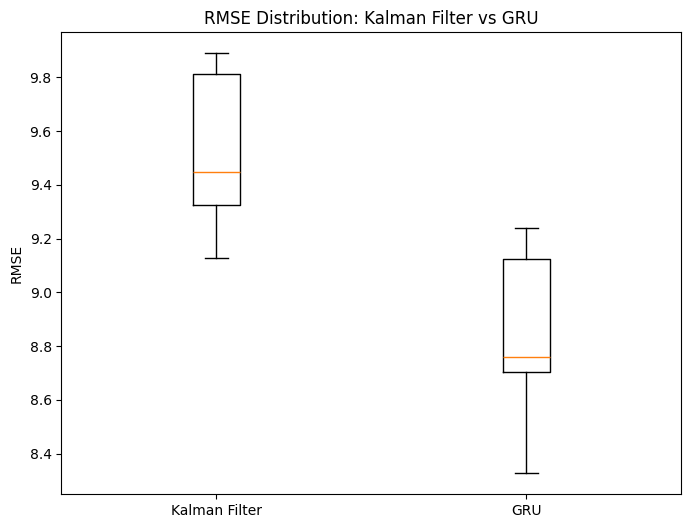

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pykalman import KalmanFilter
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings('ignore')

# Define helper function for creating lag features (for one-step forecasting)
def create_lag_features(series, lag=5):
    X, y = [], []
    n = len(series) - lag
    for i in range(n):
        X.append(series[i:i+lag])
        y.append(series[i+lag])
    return np.array(X), np.array(y)

# Load the dataset
df_precip = df[['Date', 'Location', 'Total Precip (mm)']].copy()
df_precip['Total Precip (mm)'] = df_precip['Total Precip (mm)'].fillna(df_precip['Total Precip (mm)'].median())
df_precip['Date'] = pd.to_datetime(df_precip['Date'])
df_precip = df_precip.sort_values('Date').reset_index(drop=True)

time_series = df_precip['Total Precip (mm)'].values

lag = 5
X_series, y_series = create_lag_features(time_series, lag=lag)

# Ensure both arrays have the same length
min_length = min(len(X_series), len(y_series))
X_series = X_series[:min_length]
y_series = y_series[:min_length]
print("Length of X_series:", len(X_series), "and y_series:", len(y_series))

# Number of repeated experiments (with different train/test splits)
num_repeats = 5

# Lists to store RMSE values for each method across runs
rmse_kf_runs = []
rmse_gru_runs = []

# Function to run one experiment given a random seed
def run_experiment(seed):
    # Split the data (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(X_series, y_series, test_size=0.2, random_state=seed)

    # Kalman Filter Forecasting

    # Initialize the Kalman Filter (1D) with example parameters
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=X_train[0, -1],
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)


    combined_obs = np.concatenate([X_train[:, -1], X_test[:, -1]])
    state_means, _ = kf.filter(combined_obs)

    kalman_preds = state_means[len(X_train):]
    rmse_kf = np.sqrt(mean_squared_error(y_test, kalman_preds))

    # GRU Forecasting
    # Reshape data for GRU: [samples, timesteps, features]
    X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build a simple GRU model
    model = Sequential()
    model.add(GRU(32, input_shape=(lag, 1), return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))  # linear activation for regression
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

    # Train the GRU model
    model.fit(X_train_gru, y_train, epochs=20, batch_size=32, verbose=0)

    # Forecast using GRU
    gru_preds = model.predict(X_test_gru).flatten()
    rmse_gru = np.sqrt(mean_squared_error(y_test, gru_preds))

    return rmse_kf, rmse_gru

# Run repeated experiments using different random seeds
for seed in range(42, 42 + num_repeats):
    rmse_kf, rmse_gru = run_experiment(seed)
    rmse_kf_runs.append(rmse_kf)
    rmse_gru_runs.append(rmse_gru)
    print(f"Seed {seed}: Kalman RMSE = {rmse_kf:.3f}, GRU RMSE = {rmse_gru:.3f}")

# Convert results to numpy arrays for analysis
rmse_kf_runs = np.array(rmse_kf_runs)
rmse_gru_runs = np.array(rmse_gru_runs)

# Paired t-test between Kalman Filter and GRU RMSE
t_stat, p_value = ttest_rel(rmse_kf_runs, rmse_gru_runs)
print("\nPaired t-test comparing RMSE of Kalman Filter vs GRU:")
print(f"t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

# Visualize the RMSE distributions using a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([rmse_kf_runs, rmse_gru_runs], labels=["Kalman Filter", "GRU"])
plt.ylabel("RMSE")
plt.title("RMSE Distribution: Kalman Filter vs GRU")
plt.show()
